In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import TPI
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_overlap, get_mismatch, get_separatrix, get_fundamental_frequencies, get_fundamental_frequencies_spin_corrections
from scipy.interpolate import RegularGridInterpolator
import time

trajpn5 = EMRIInspiral(func="pn5")
trajS = EMRIInspiral(func="SchwarzEccFlux")
trajK = EMRIInspiral(func="KerrEccentricEquatorial")

def pdotpn(a, p, e, pLSO):
    """
    https://arxiv.org/pdf/2201.07044.pdf
    eq 91
    """
    risco = get_separatrix(a+1e-200, np.zeros_like(a), np.ones_like(a))
    U2 = (p - risco)**2 - (pLSO - risco)**2
    pdot_V = 8./5. * p**(-3) * (1-e**2)**1.5 * (8 + 7 * e**2) * (p**2 / U2)
    return pdot_V

def edotpn(a, p, e, pLSO):
    """
    https://arxiv.org/pdf/2201.07044.pdf
    eq 91
    without the factor of e
    """
    risco = get_separatrix(a+1e-200, np.zeros_like(a), np.ones_like(a))
    U2 = (p - risco)**2 - (pLSO - risco)**2
    return 1/15 * p**(-4) * (1-e**2)**1.5 * (304 + 121 * e**2) * (p**2 / U2)


In [2]:
a=0.85
epsilon = 1e-5
p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid( np.linspace(4.0, 14.0), np.linspace(0.01, 0.5))])

tic = time.time()
outV = np.asarray([trajK.get_derivative(epsilon, a, pp, ee, 1.0, np.asarray([0.0]))  for pp,ee in zip(p_all,e_all)])
toc = time.time()
print("V",(toc-tic)/len(p_all))

tic = time.time()
outB = np.asarray([trajK.get_derivative(epsilon, a, pp, ee, 1.0, np.asarray([1.0]))  for pp,ee in zip(p_all,e_all)])
toc = time.time()
print("B",(toc-tic)/len(p_all))

tic = time.time()
outH = np.asarray([trajK.get_derivative(epsilon, a, pp, ee, 1.0, np.asarray([-1.0]))  for pp,ee in zip(p_all,e_all)])
toc = time.time()
print("H",(toc-tic)/len(p_all))

V 1.4820384979248047e-05
B 1.849393844604492e-05
H 1.4088821411132812e-05


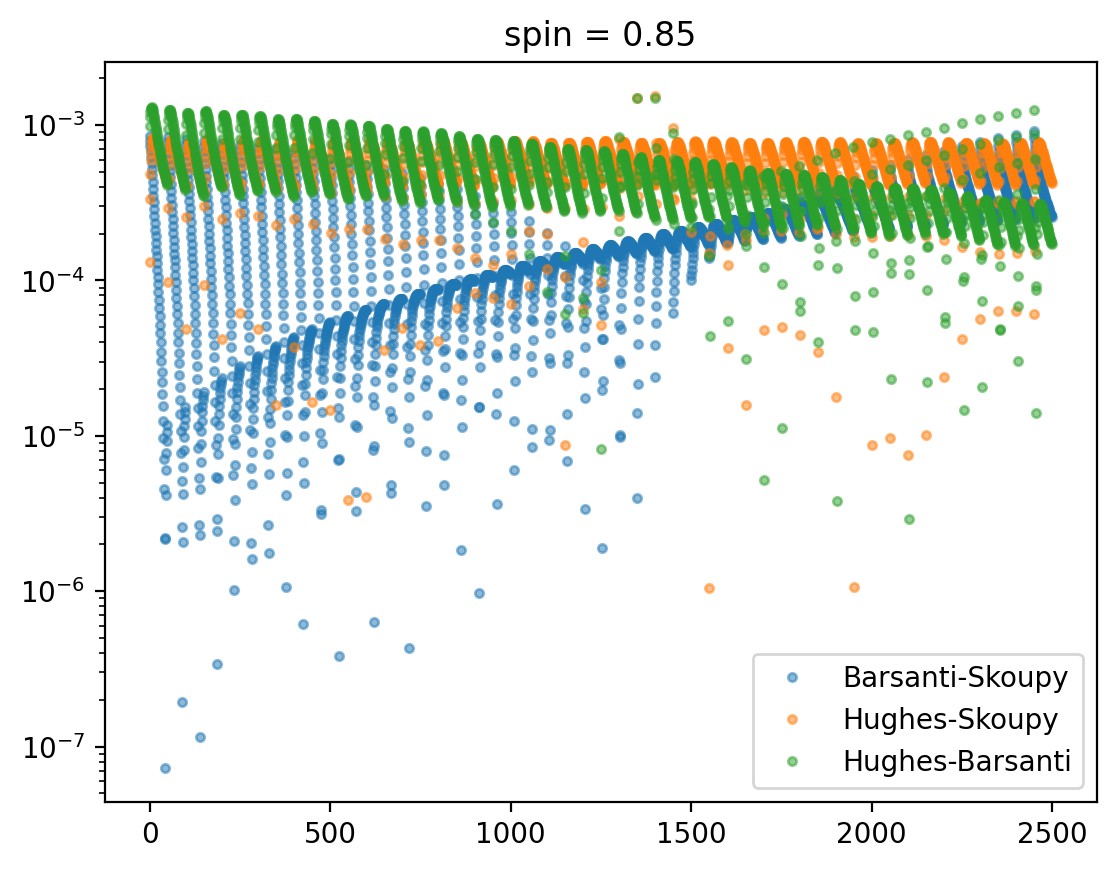

In [7]:

ind=1
plt.figure()
plt.title(f'spin = {a}')
varBS = np.abs(1-outB[:,ind]/outV[:,ind] )
plt.semilogy(varBS,'.',label='Barsanti-Skoupy',alpha=0.5)
varHS = np.abs(1-outH[:,ind]/outV[:,ind] )
plt.semilogy(varHS,'.',label='Hughes-Skoupy',alpha=0.5)
varHB = np.abs(1-outH[:,ind]/outB[:,ind] )
plt.semilogy(varHB,'.',label='Hughes-Barsanti',alpha=0.5)
plt.legend()
plt.show()

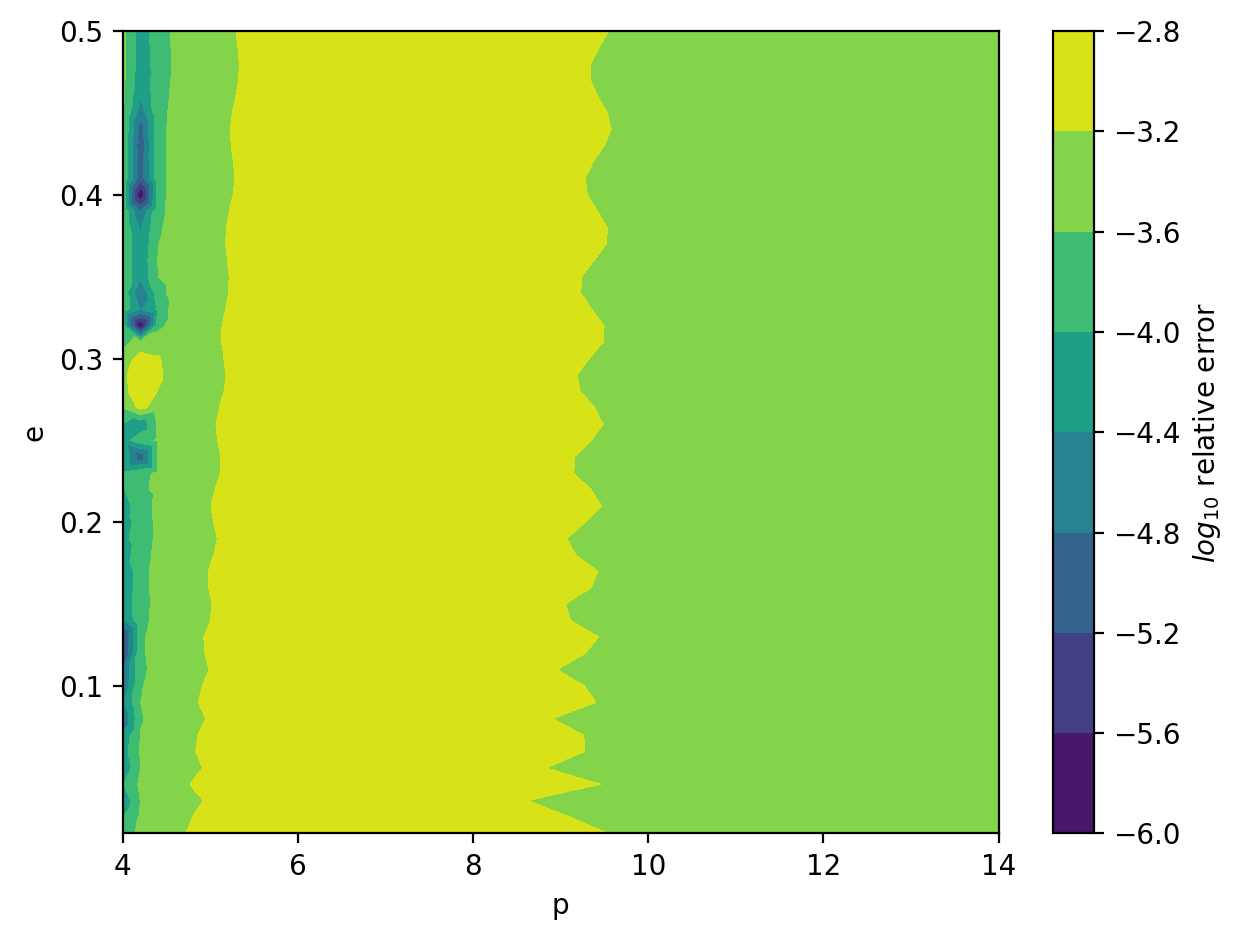

In [9]:
plt.figure()
cb= plt.tricontourf(p_all, e_all, np.log10(varHS))
plt.colorbar(cb,label=r'$log_{10} $ relative error')
plt.xlabel('p')
plt.ylabel('e')
plt.tight_layout()

## 4D TP spline interpolation

In [117]:
!ls few/files/*.h5

few/files/Teuk_amps_a0.00_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.0_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.10_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.20_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.30_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.40_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.50_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.60_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.70_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.80_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.90_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.95_p_lmax_10_nmax_30_new.h5
few/files/Teuk_amps_a0.99_p_lmax_10_nmax_30_new.h5


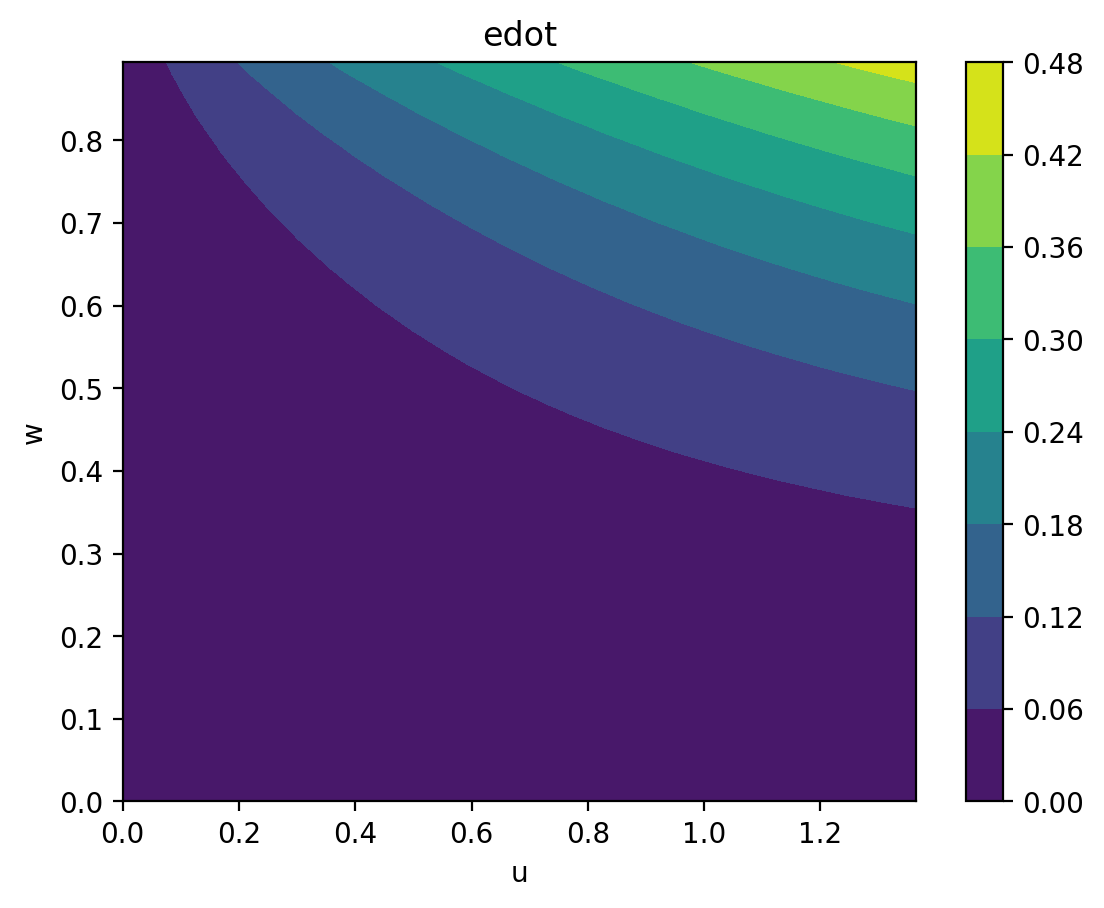

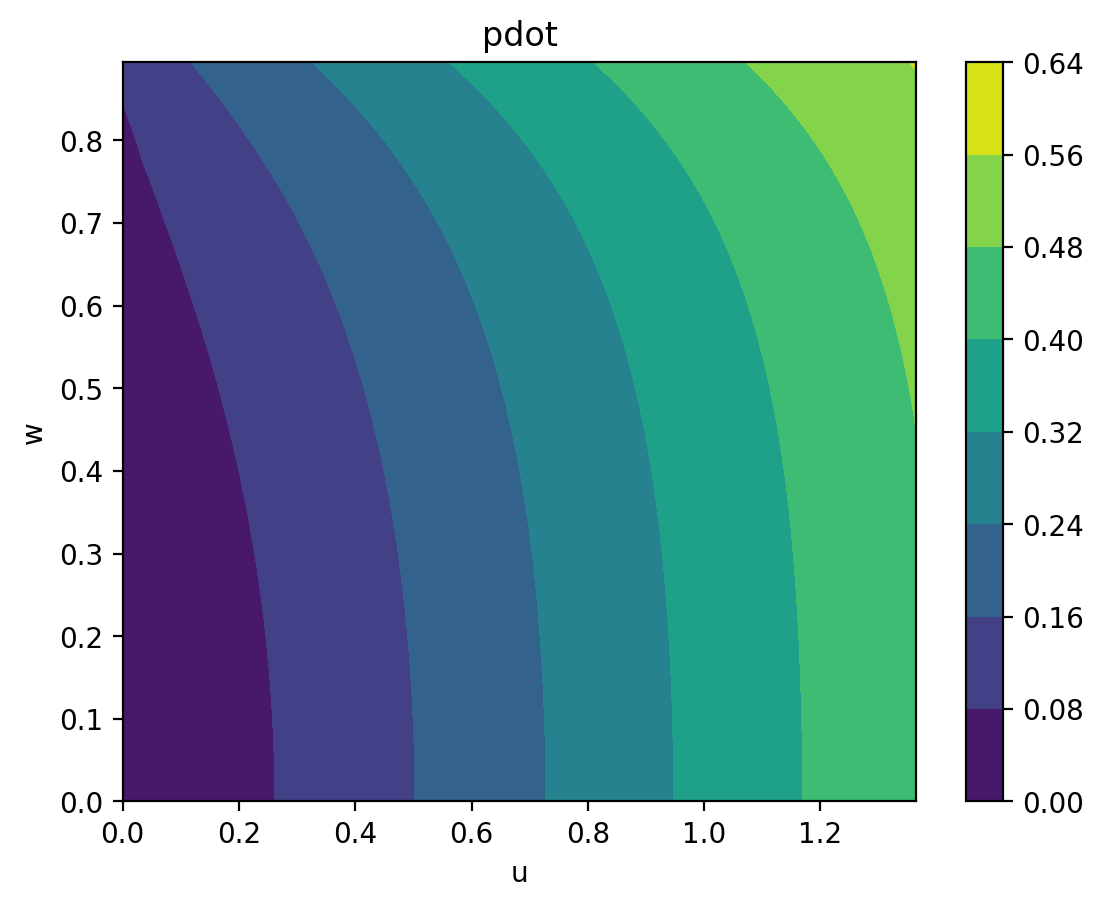

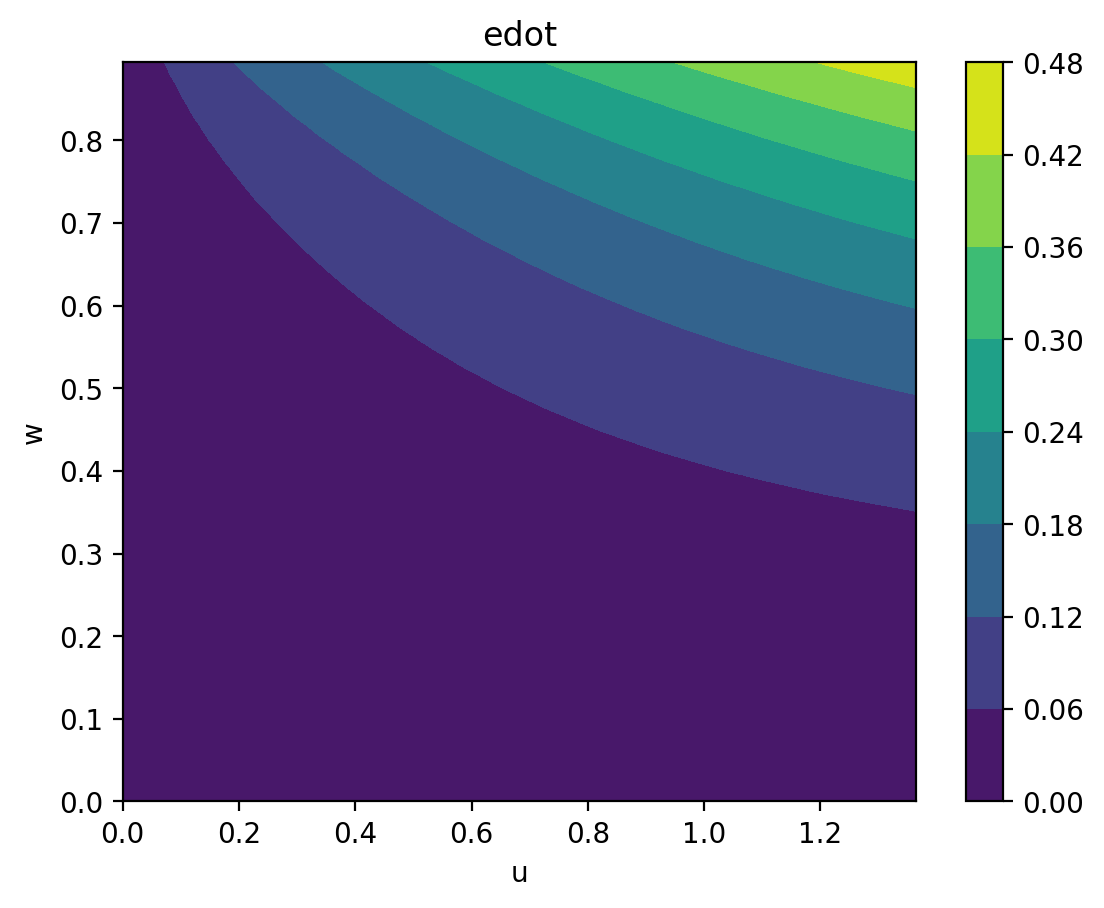

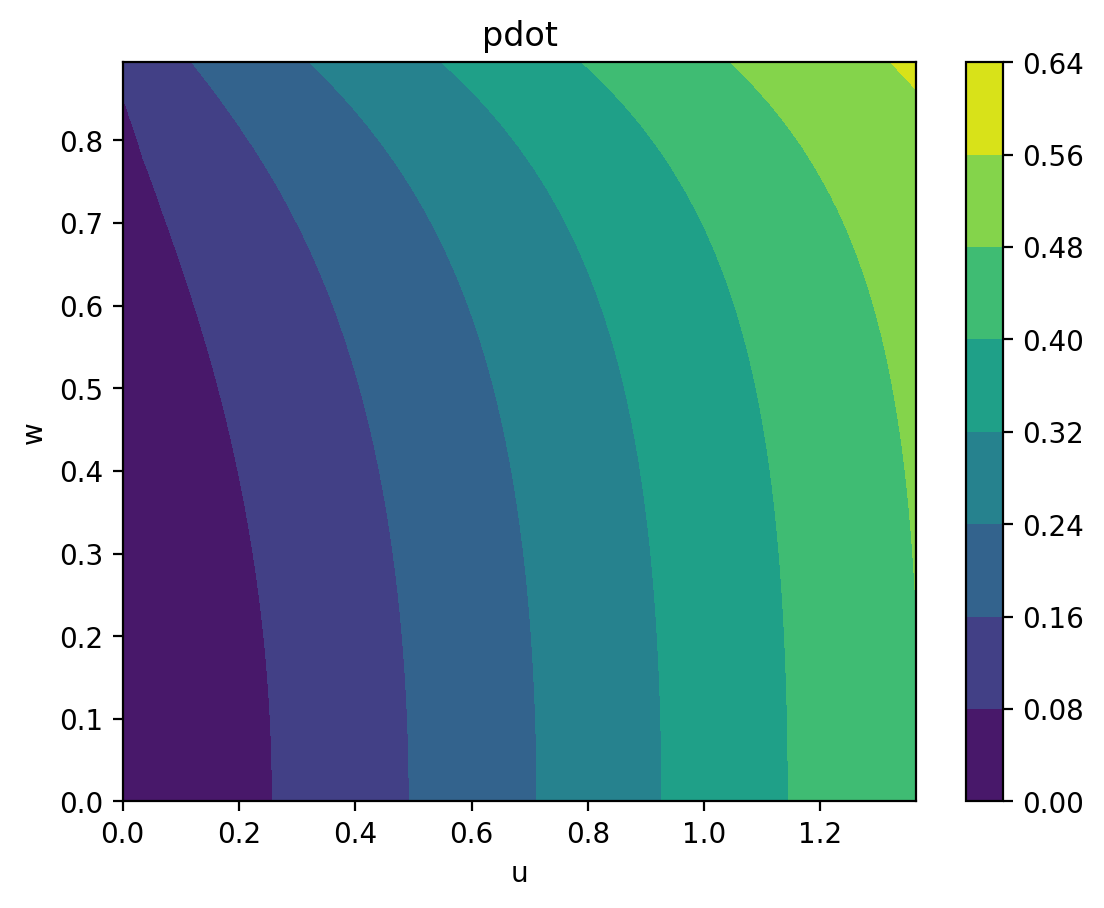

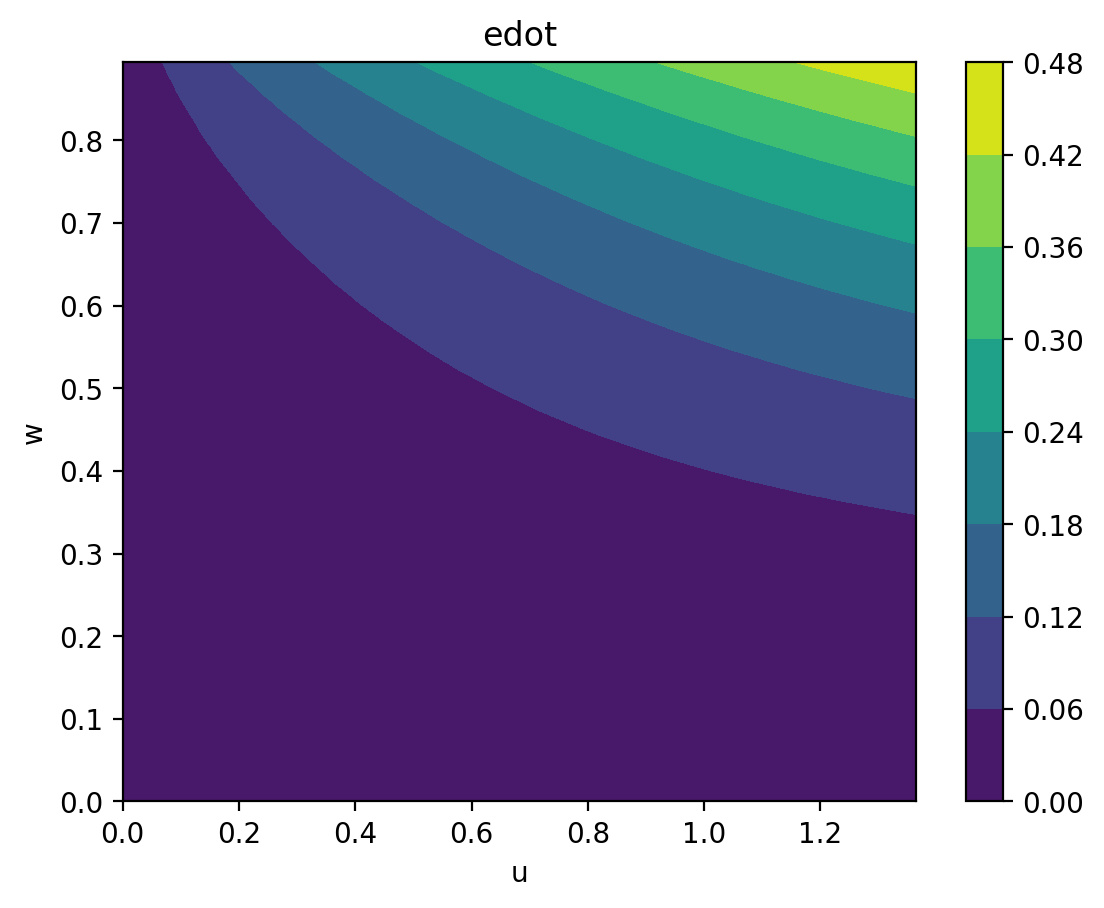

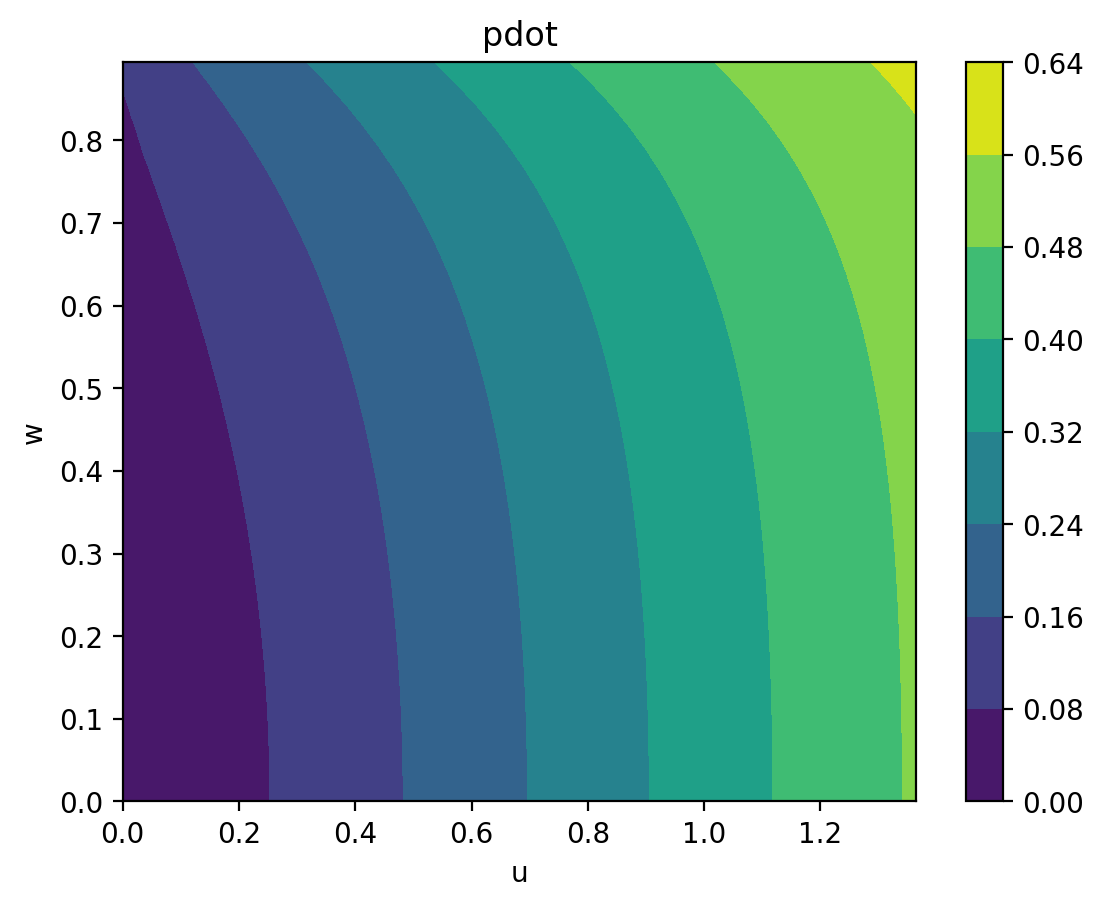

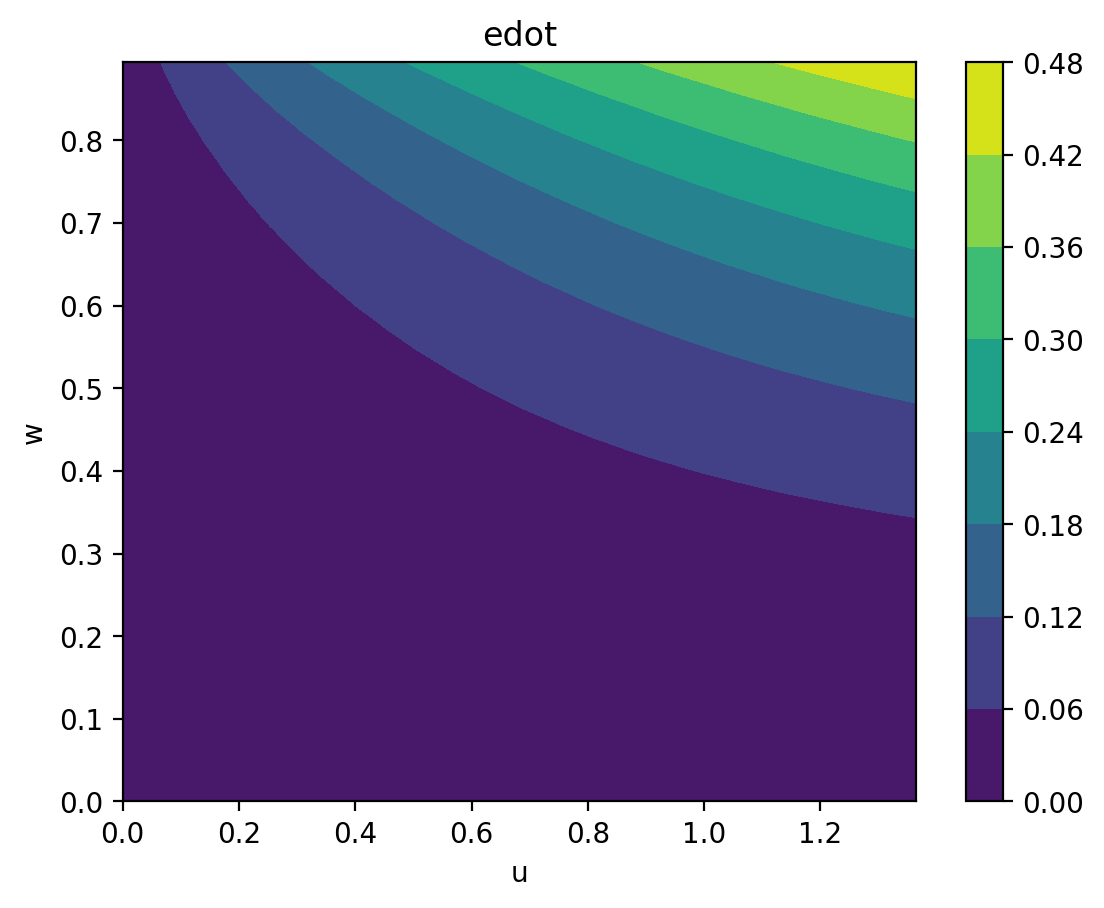

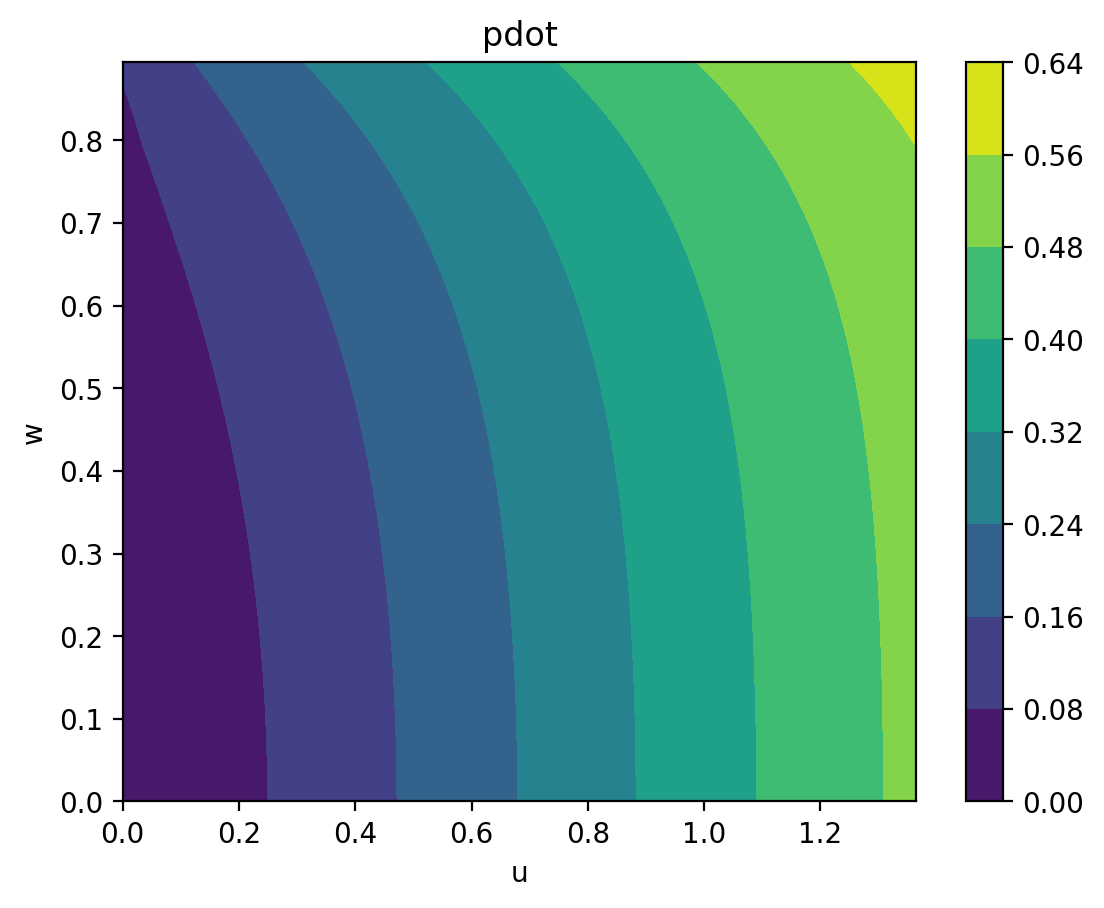

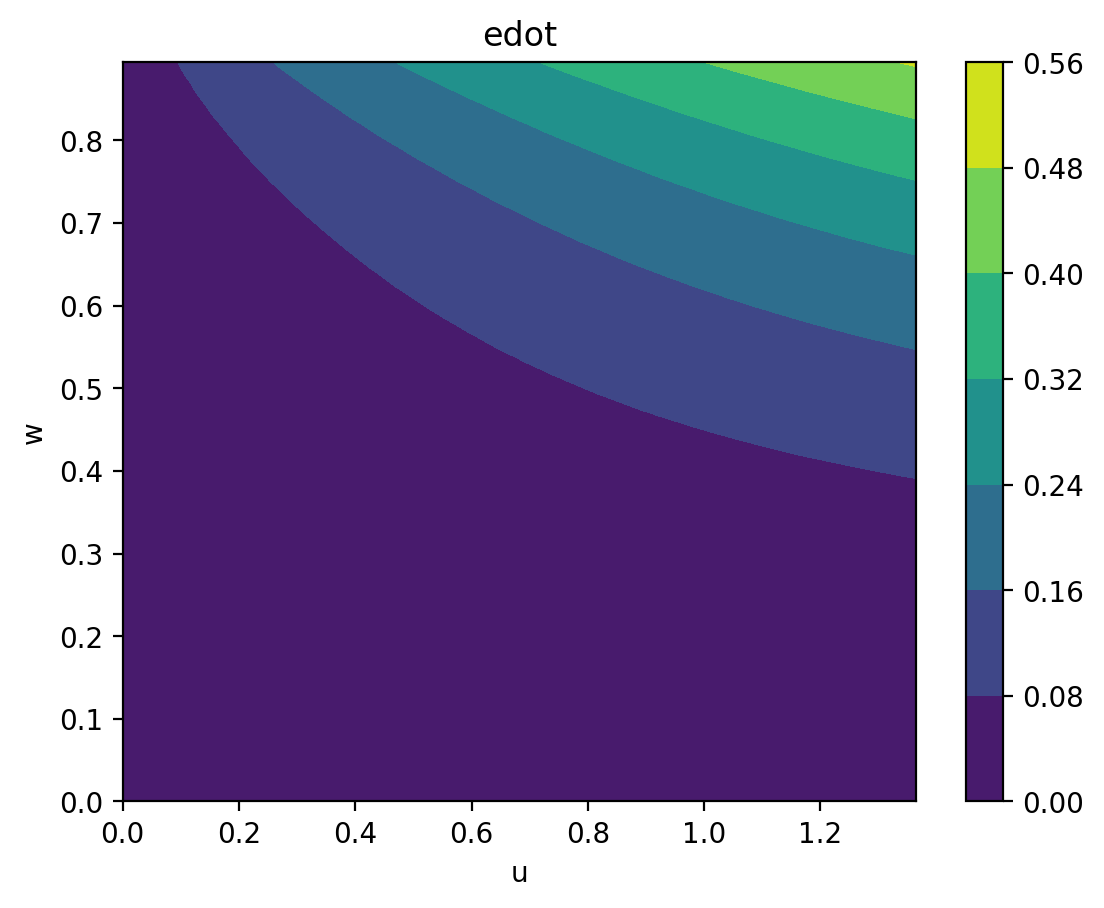

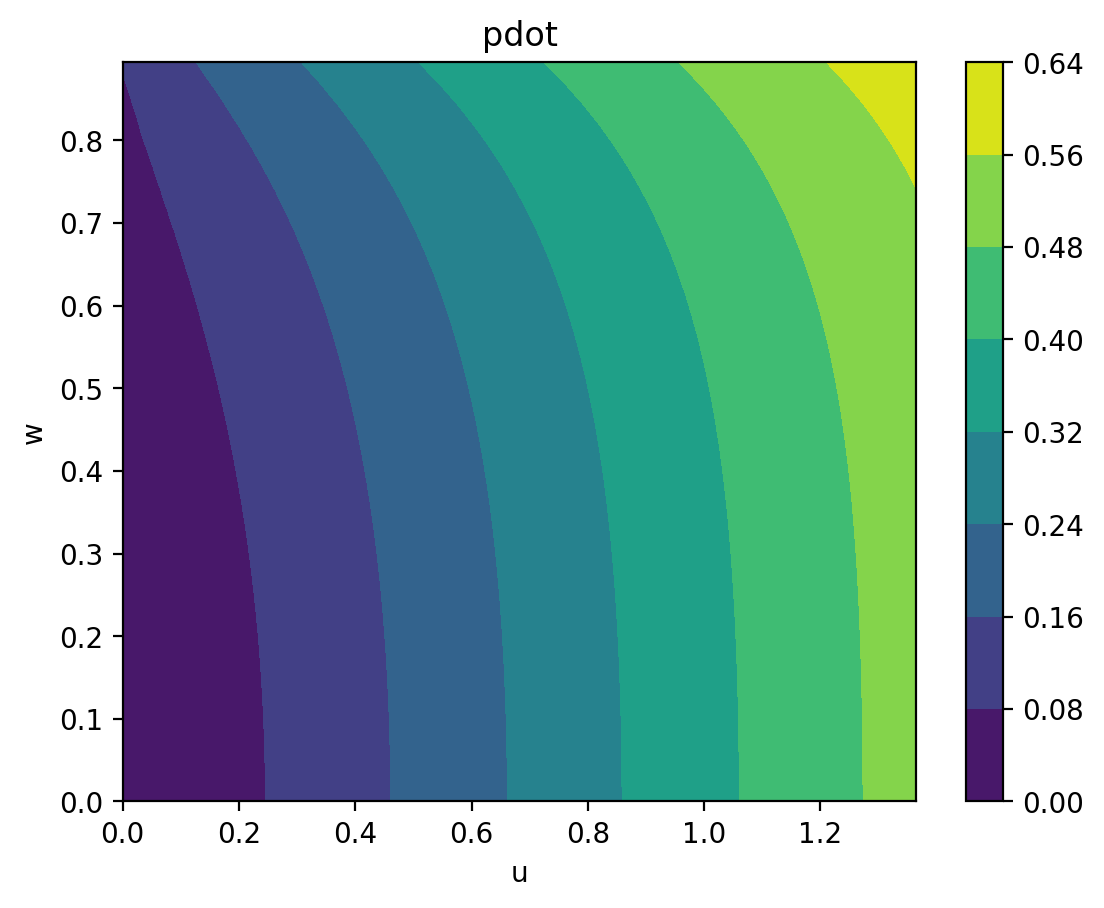

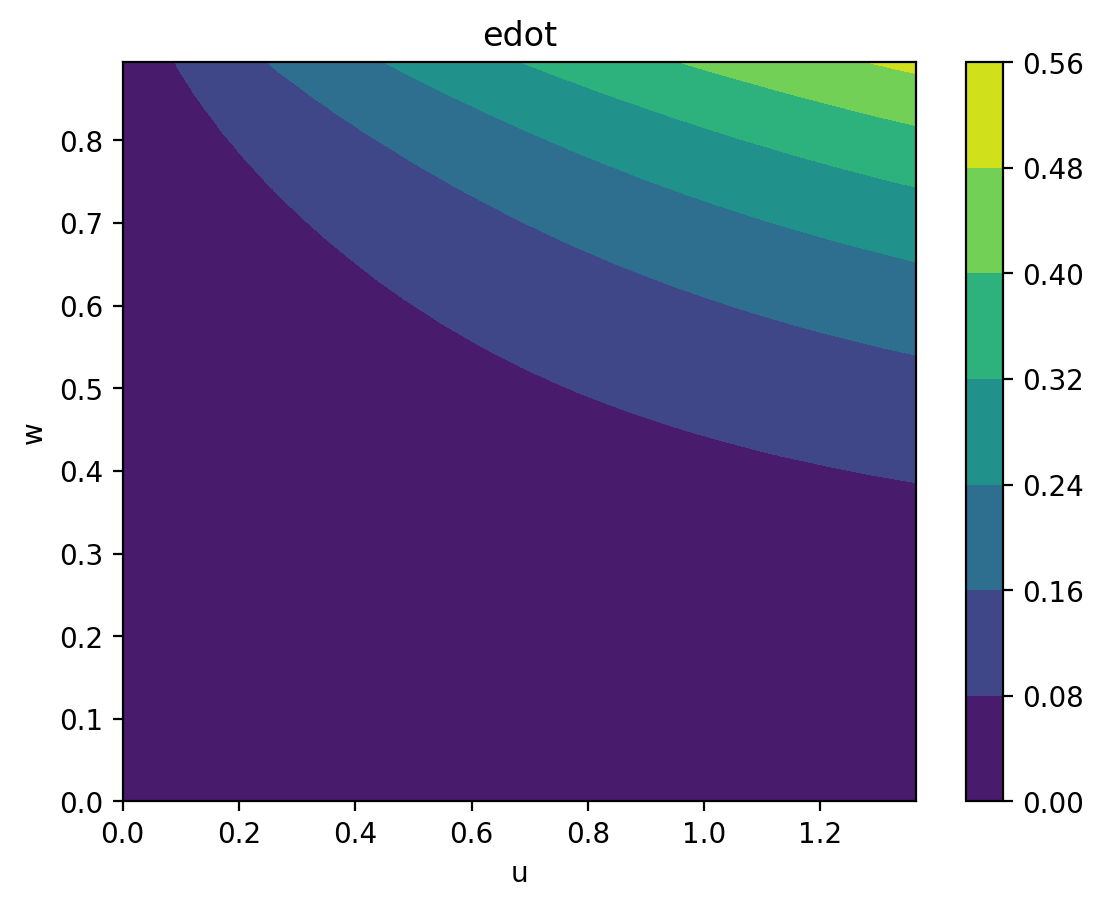

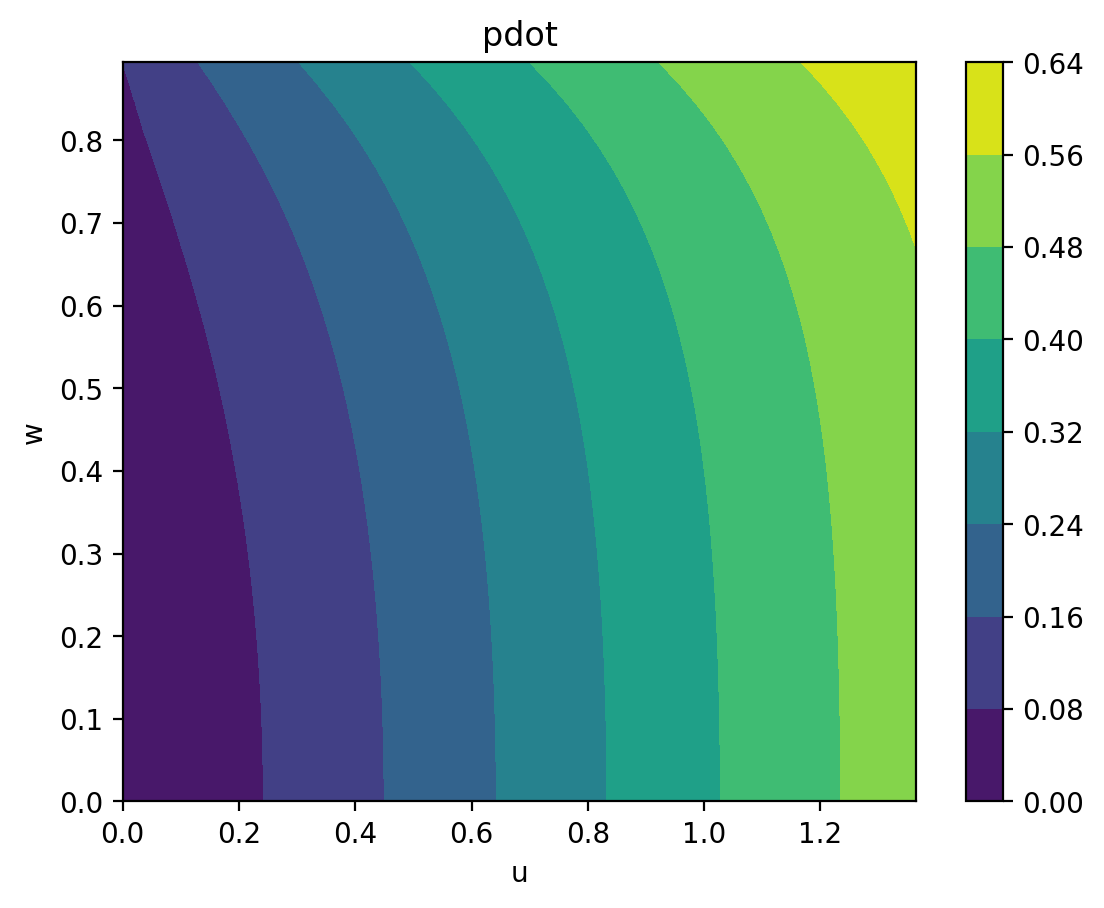

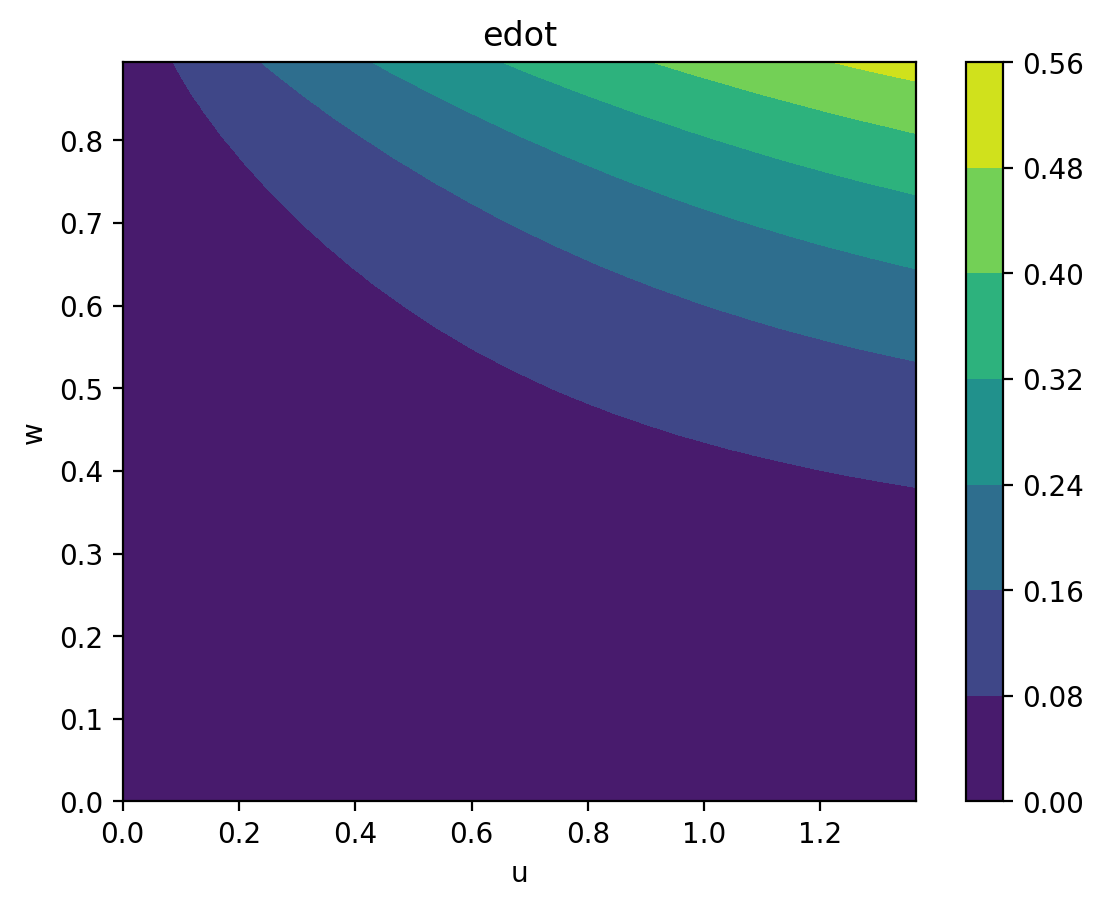

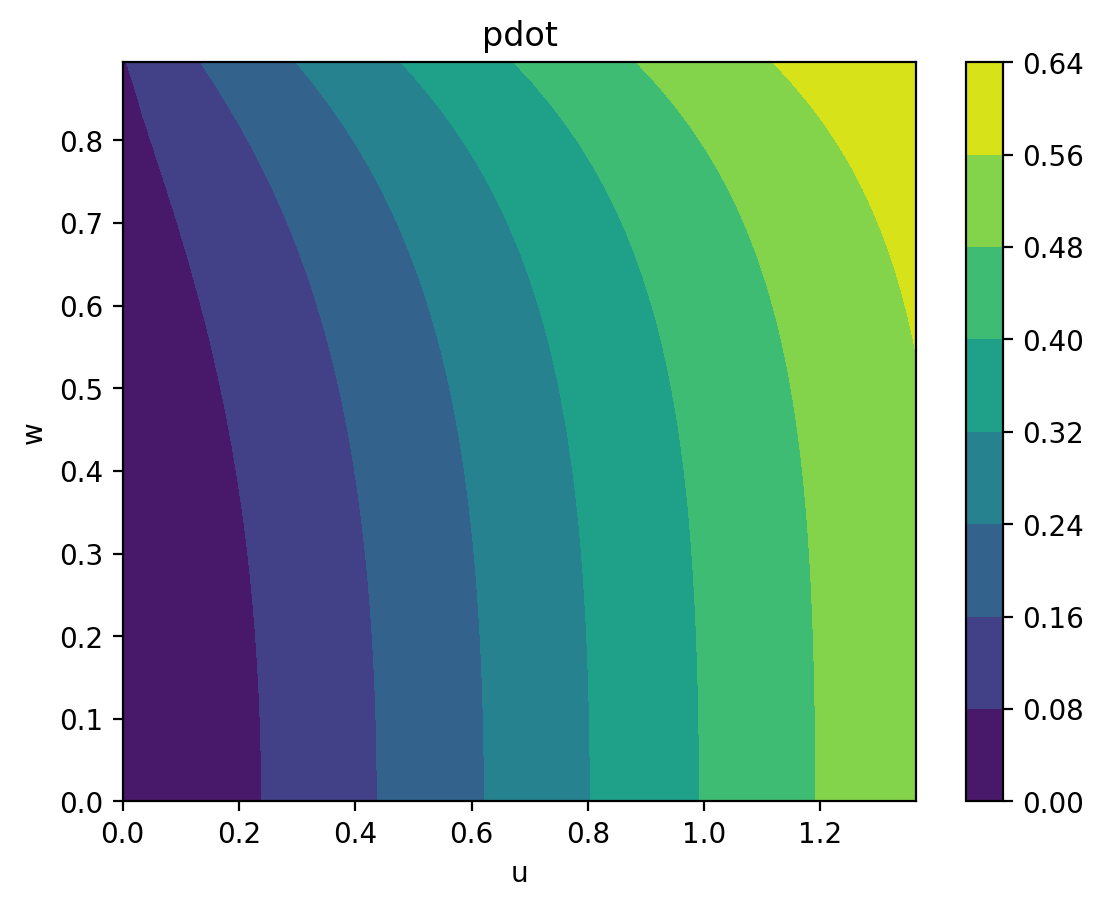

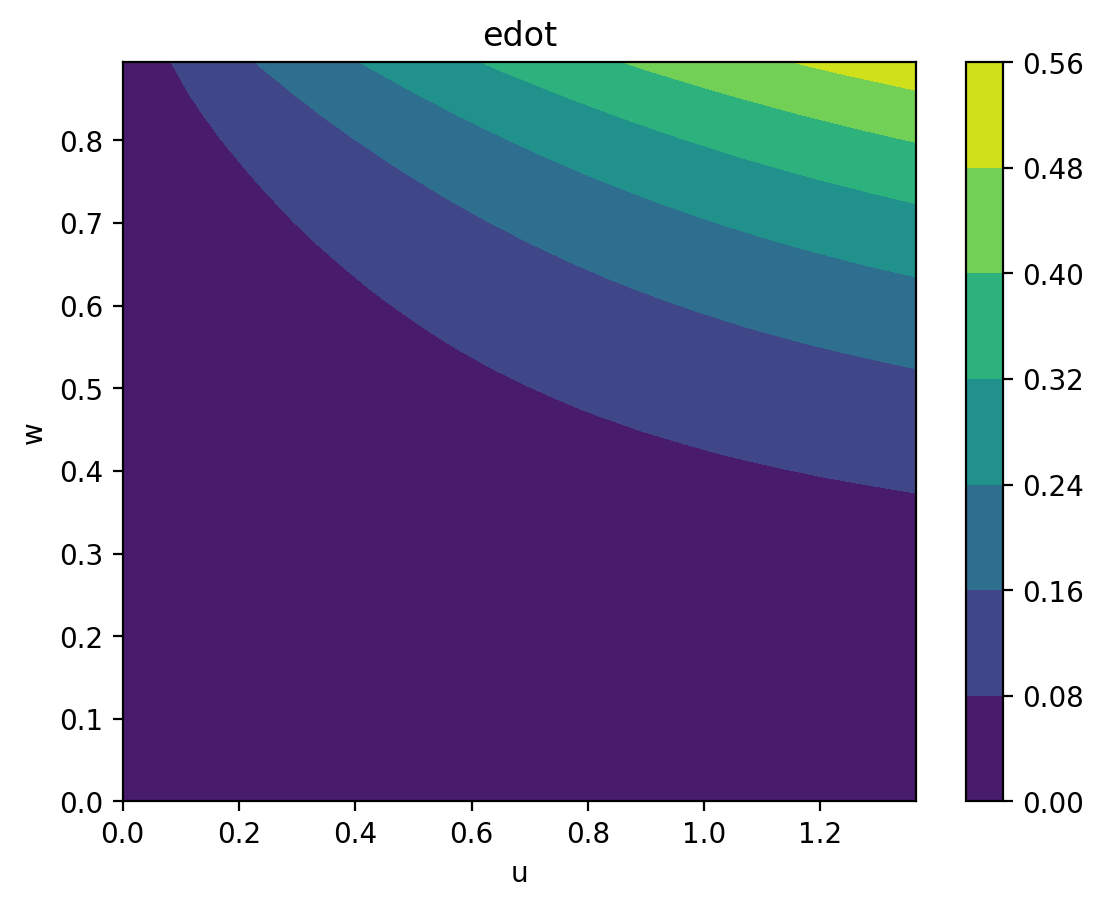

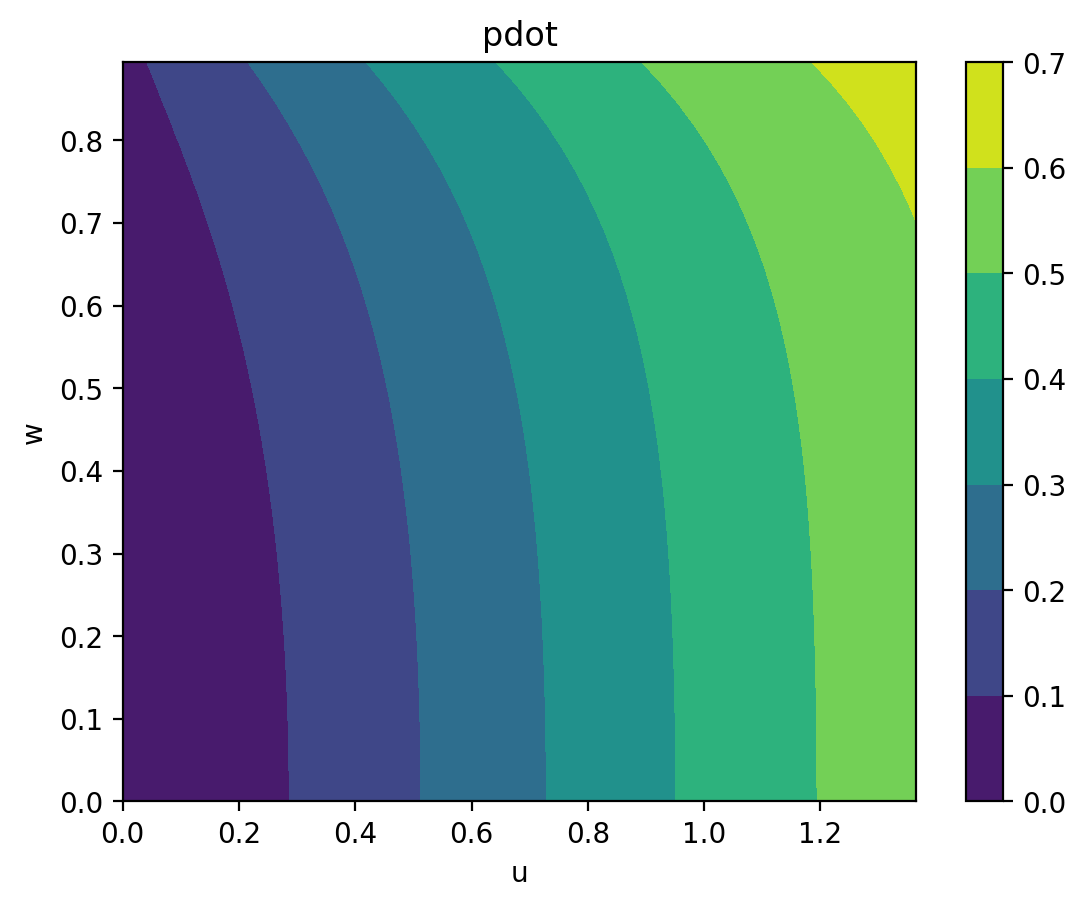

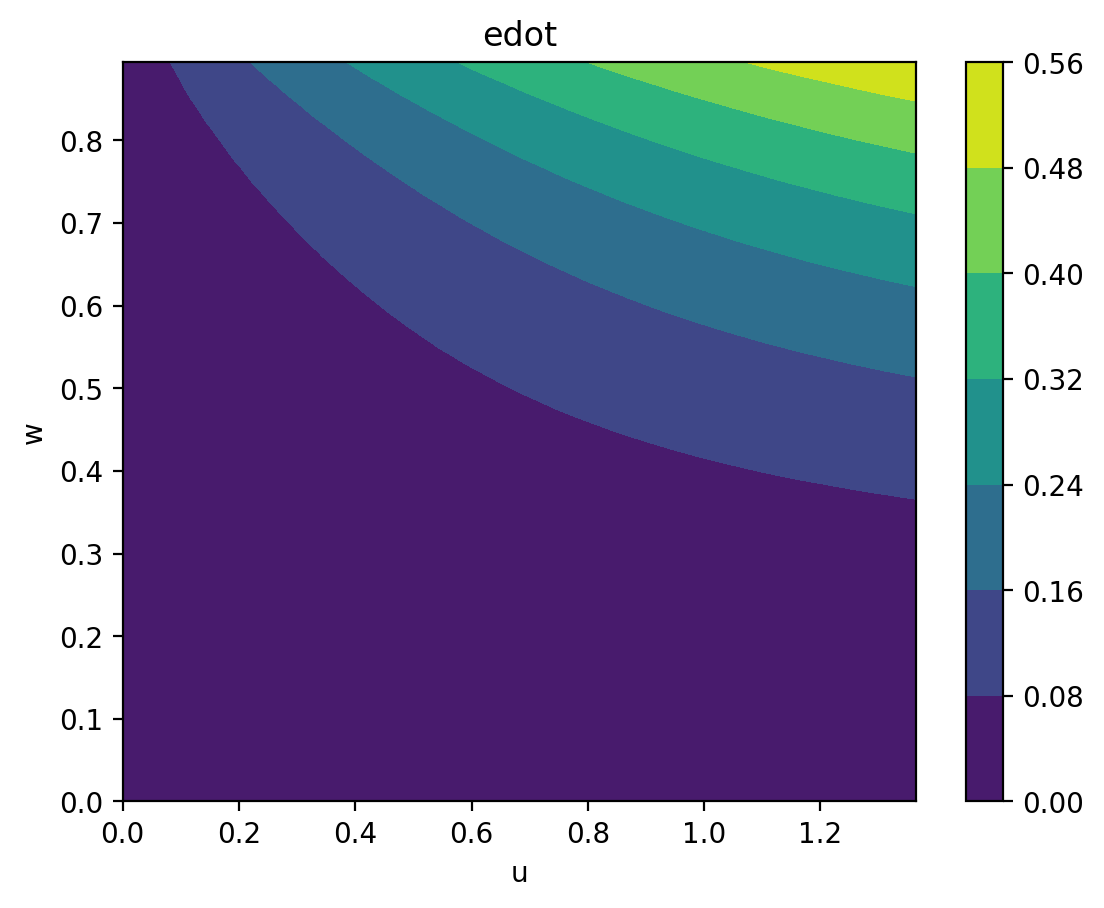

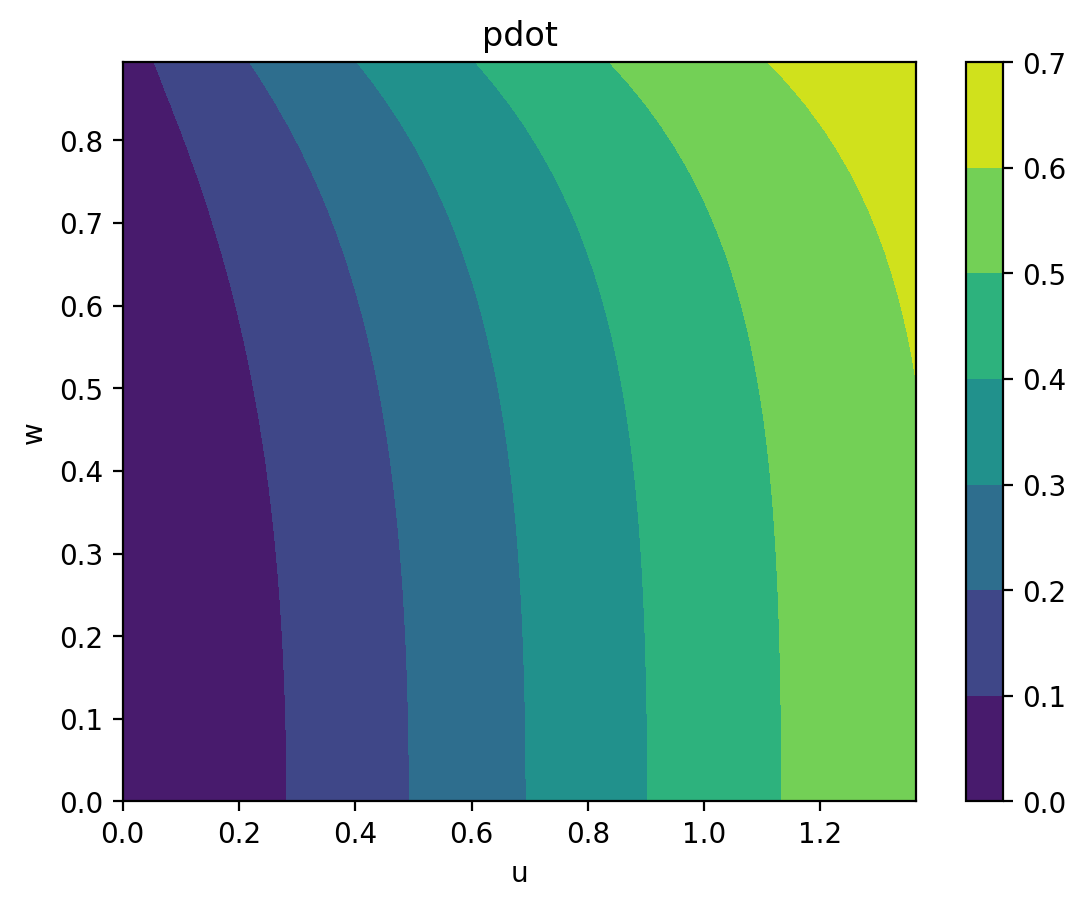

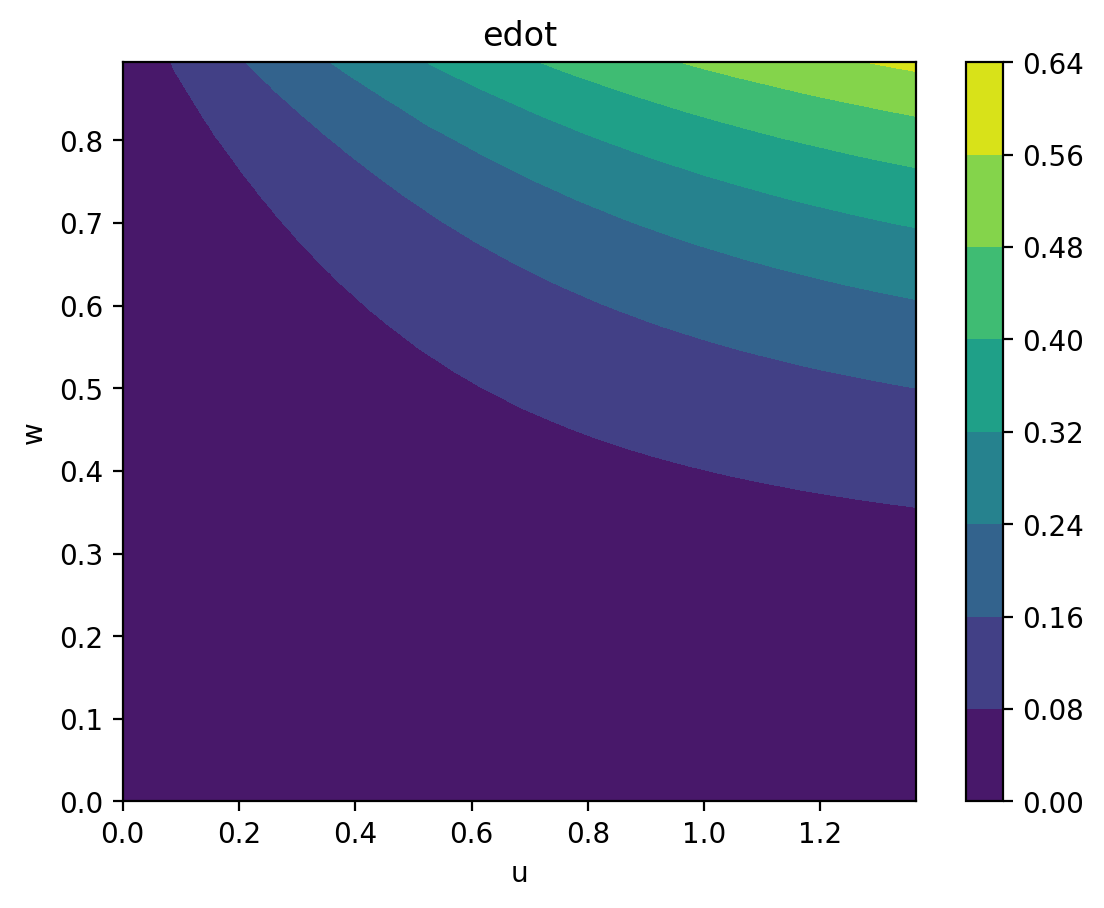

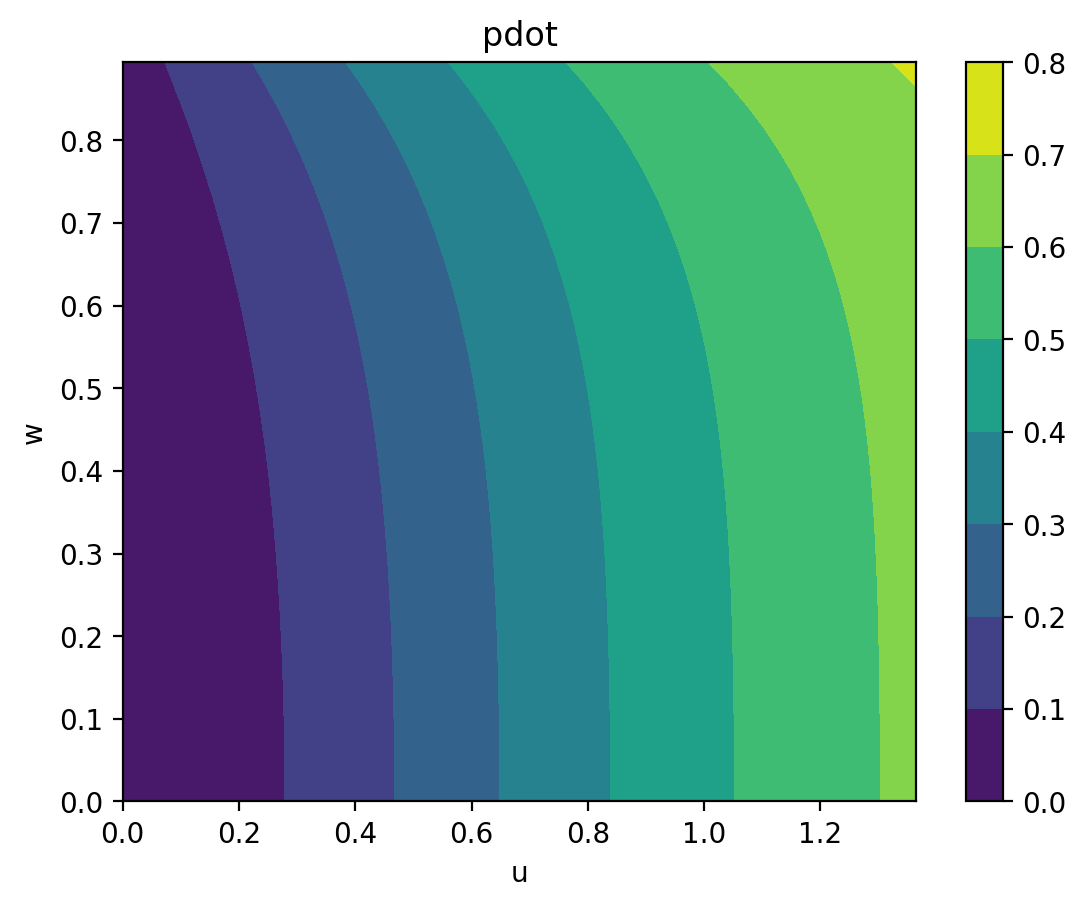

In [118]:
import glob
a_tot, u_tot, w_tot = [], [], []
pdot = []
edot = []
plso = []

alpha = 4.0
deltap = 0.05
beta = alpha - deltap

for aa in np.arange(0,10):
    el = f'few/files/a0.{aa}0_xI1.000.flux'
    imp = np.loadtxt(el)
    a, p, e, xi, E, Lz, Q, pLSO, EdotInf_tot, EdotH_tot, LzdotInf_tot, LzdotH_tot, QdotInf_tot, QdotH_tot, pdotInf_tot, pdotH_tot, eccdotInf_tot, eccdotH_tot, xidotInf_tot, xidotH_tot = imp.T
    u = np.log((p-pLSO + beta)/alpha)
    w = np.sqrt(e)
    a_tot.append(a )
    u_tot.append(u )
    w_tot.append(w )
    pdot.append(pdotInf_tot+pdotH_tot)
    edot.append(eccdotInf_tot+eccdotH_tot)
    plso.append(pLSO )

#     plt.figure()
#     plt.plot(u[sortind])
#     plt.show()
#     plt.figure()
#     plt.plot(w[sortind])
#     plt.show()

#     plt.figure()
#     plt.tricontourf(u,w, np.abs(pdotInf_tot+pdotH_tot)/pdotpn(p,e) )
#     plt.colorbar()
#     plt.xlabel('p')
#     plt.ylabel('e')
#     plt.show()
    
#     plt.figure()
#     plt.title('pdot')
#     plt.plot(u, np.abs(pdotInf_tot+pdotH_tot)/ pdotpn(a, p, e, pLSO) )
#     plt.show()

    plt.figure()
    plt.title('edot')
    cb= plt.tricontourf(u,w, np.abs(eccdotInf_tot+eccdotH_tot)/edotpn(a, p, e, pLSO) )
    plt.colorbar(cb)
    plt.xlabel('u')
    plt.ylabel('w')
    plt.show()


    plt.figure()
    plt.title('pdot')
    cb= plt.tricontourf(u,w, np.abs(pdotInf_tot+pdotH_tot)/pdotpn(a, p, e, pLSO) )
    plt.colorbar(cb)
    plt.xlabel('u')
    plt.ylabel('w')
    plt.show()

# el = f'few/files/a0.95_xI1.000.flux'
# imp = np.loadtxt(el)
# a, p, e, xi, E, Lz, Q, pLSO, EdotInf_tot, EdotH_tot, LzdotInf_tot, LzdotH_tot, QdotInf_tot, QdotH_tot, pdotInf_tot, pdotH_tot, eccdotInf_tot, eccdotH_tot, xidotInf_tot, xidotH_tot = imp.T
# u = np.log((p-pLSO + beta)/alpha)
# w = e*e
# a_tot.append(a)
# u_tot.append(u)
# w_tot.append(w)
# pdot.append(pdotInf_tot+pdotH_tot)
# edot.append(eccdotInf_tot+eccdotH_tot)
# print(u.min(), u.max())
# print(w.min(), w.max())

#
# el = f'few/files/a0.99_xI1.000.flux'
# imp = np.loadtxt(el)
# a, p, e, xi, E, Lz, Q, pLSO, EdotInf_tot, EdotH_tot, LzdotInf_tot, LzdotH_tot, QdotInf_tot, QdotH_tot, pdotInf_tot, pdotH_tot, eccdotInf_tot, eccdotH_tot, xidotInf_tot, xidotH_tot = imp.T
# u = np.log((p-pLSO + beta)/alpha)
# w = e*e
# a_tot.append(a)
# u_tot.append(u)
# w_tot.append(w)
# pdot.append(pdotInf_tot+pdotH_tot)
# edot.append(eccdotInf_tot+eccdotH_tot)

In [12]:
np.loadtxt?

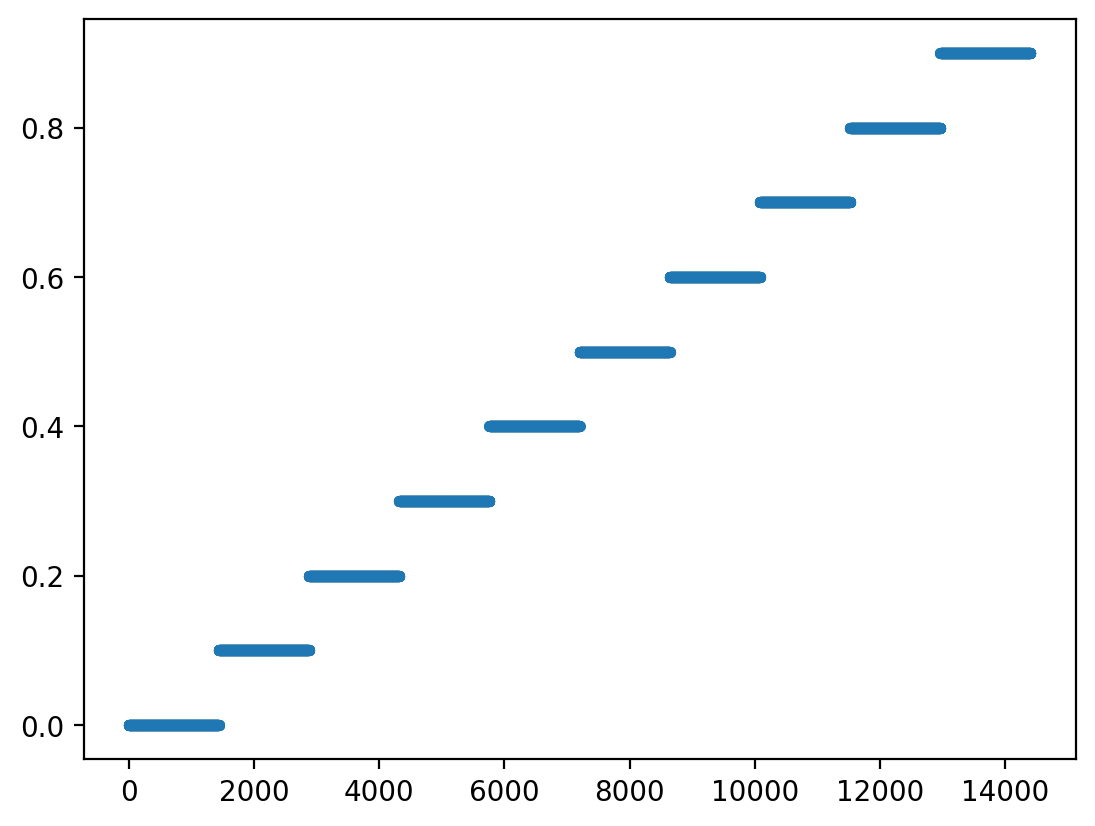

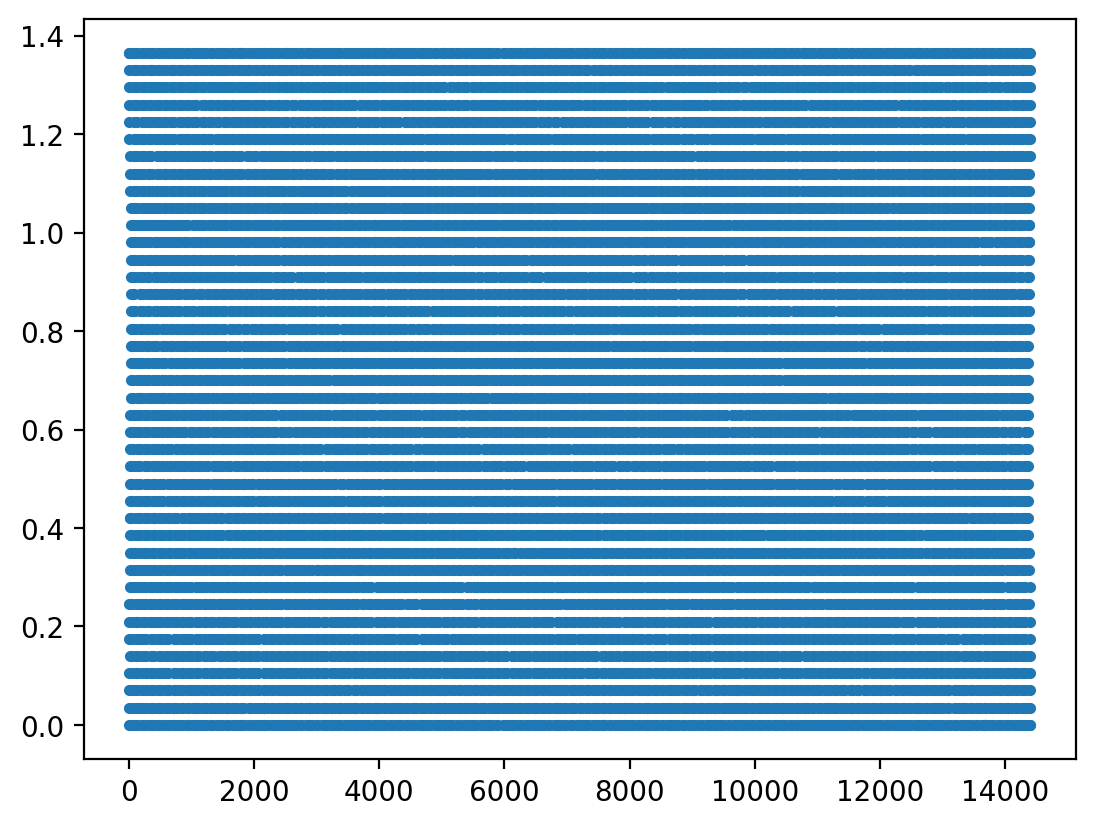

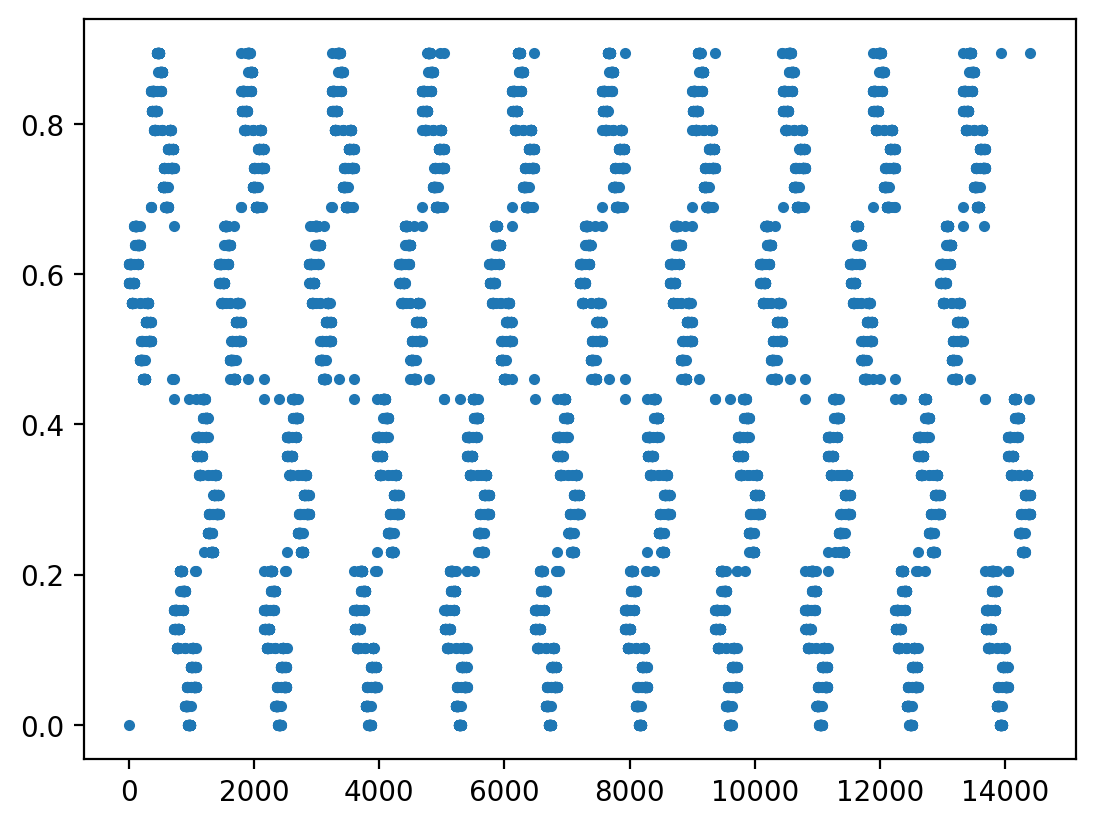

In [4]:
flat_a = np.round(np.asarray(a_tot).flatten(),decimals=5)
flat_u = np.round(np.asarray(u_tot).flatten(),decimals=5)
flat_w = np.round(np.asarray(w_tot).flatten(),decimals=5)
flat_pdot = np.asarray(pdot).flatten()

def get_pdot(aa,uu,ww):
    mask = (aa==flat_a)*(uu==flat_u)*(ww==flat_w)
    return flat_pdot[mask][0]

ind = np.argsort(flat_a)

plt.figure()
plt.plot(flat_a[ind],'.')
plt.show()


plt.figure()
plt.plot(flat_u[ind],'.')
plt.show()

plt.figure()
plt.plot(flat_w[ind],'.')
plt.show()


In [5]:
a_unique = np.unique(flat_a)
u_unique = np.unique(flat_u)
w_unique = np.unique(flat_w)

x1 = a_unique.copy()
x2 = u_unique.copy()
x3 = w_unique.copy()
X = [x1, x2, x3]

print(x1.shape[0], x2.shape[0], x3.shape[0])

get_pdot(a_unique[2], u_unique[3], w_unique[5])

10 40 36


-0.2838731539113904

In [6]:
reshapedF = np.asarray([[[ get_pdot(el1,el2,el3) for el3 in x3] for el2 in x2] for el1 in x1])
print(reshapedF.shape)
# flux interpolation
InterpFlux = TPI.TP_Interpolant_ND(X, F=reshapedF)
ScipyFlux = RegularGridInterpolator((x1, x2, x3), reshapedF)

(10, 40, 36)


In [7]:
InterpFlux.GetSplineCoefficientsND().flatten()

array([-2.84412156e+00, -2.84624252e+00, -2.79084874e+00, ...,
       -1.63631038e-03, -1.41671741e-03, -1.30284991e-03])

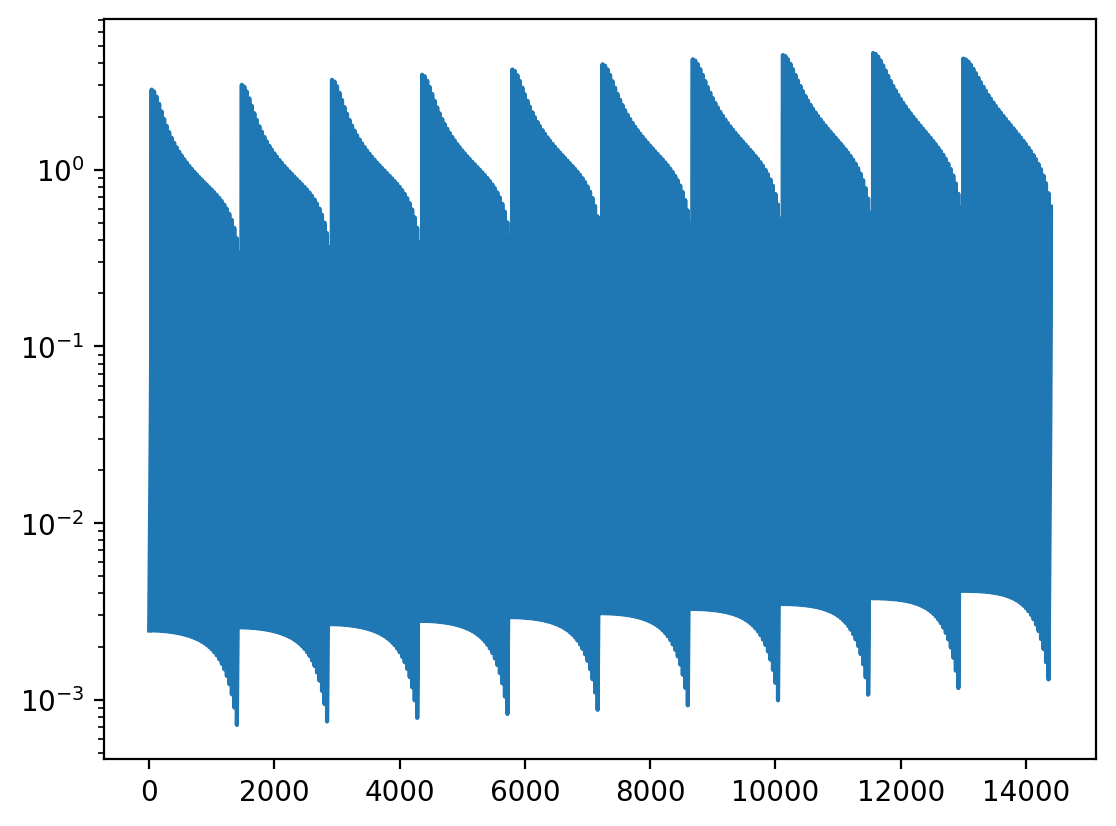

In [8]:
plt.semilogy(np.abs(flat_pdot))

# Comparison to 5 PN

In [9]:
def pn5_pdot_edot(aa,pp,ee):
    epsilon = 1e-4
    out = trajpn5.get_derivative(epsilon, aa, pp, ee, 1.0, np.asarray([0.0]))
    pdot = out[0] / epsilon
    if np.isnan(pdot):
        print(aa,pp,ee)
    return pdot

def Schwarz_pdot_edot(aa,pp,ee):
    epsilon = 1e-4
    out = trajS.get_derivative(epsilon, 0.0, pp, ee, 1.0, np.asarray([0.0]))
    pdot = out[0] / epsilon
    if np.isnan(pdot):
        print(aa,pp,ee)
    return pdot


In [10]:
def f(xx1,xx2,xx3):
    ee = xx3**2
    sep = get_separatrix(xx1, ee, 1.0)
    pp = np.exp(xx2)*alpha + sep - beta
    return pn5_pdot_edot(xx1, pp, ee)

def fS(xx1,xx2,xx3):
    ee = xx3**2
    sep = get_separatrix(xx1, ee, 1.0)
    pp = np.exp(xx2)*alpha + sep - beta
    return Schwarz_pdot_edot(xx1, pp, ee)

0.0 6.1504677416131655 0.05003386080624999
0.0 6.805570516444992 0.05003386080624999
0.0 7.567952474220198 0.05003386080624999
0.0 8.45518158066135 0.05003386080624999
0.0 9.487702719558055 0.05003386080624999
0.0 10.689308814904603 0.05003386080624999
0.0 12.087689103676997 0.05003386080624999
0.0 13.715067193385494 0.05003386080624999
0.0 15.608943607496158 0.05003386080624999
0.0 17.81295992958339 0.05003386080624999


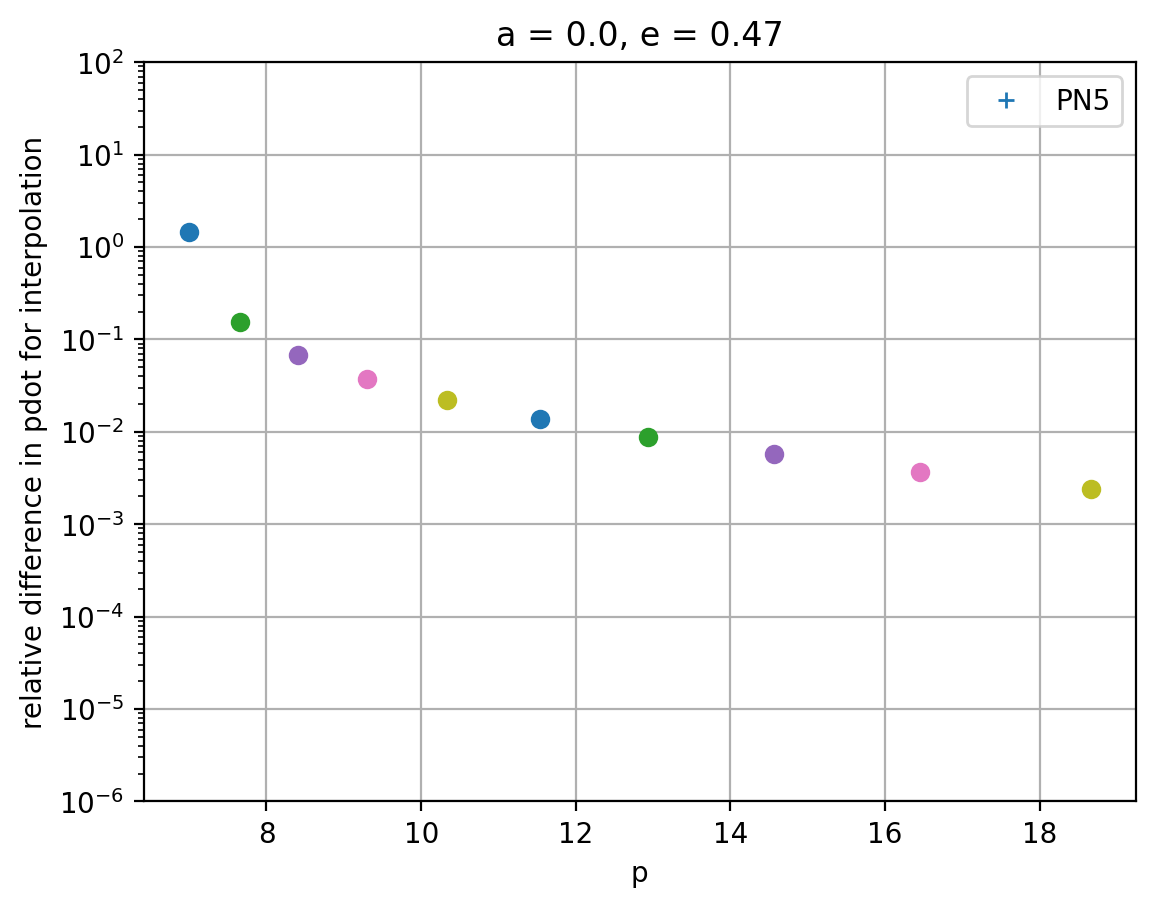

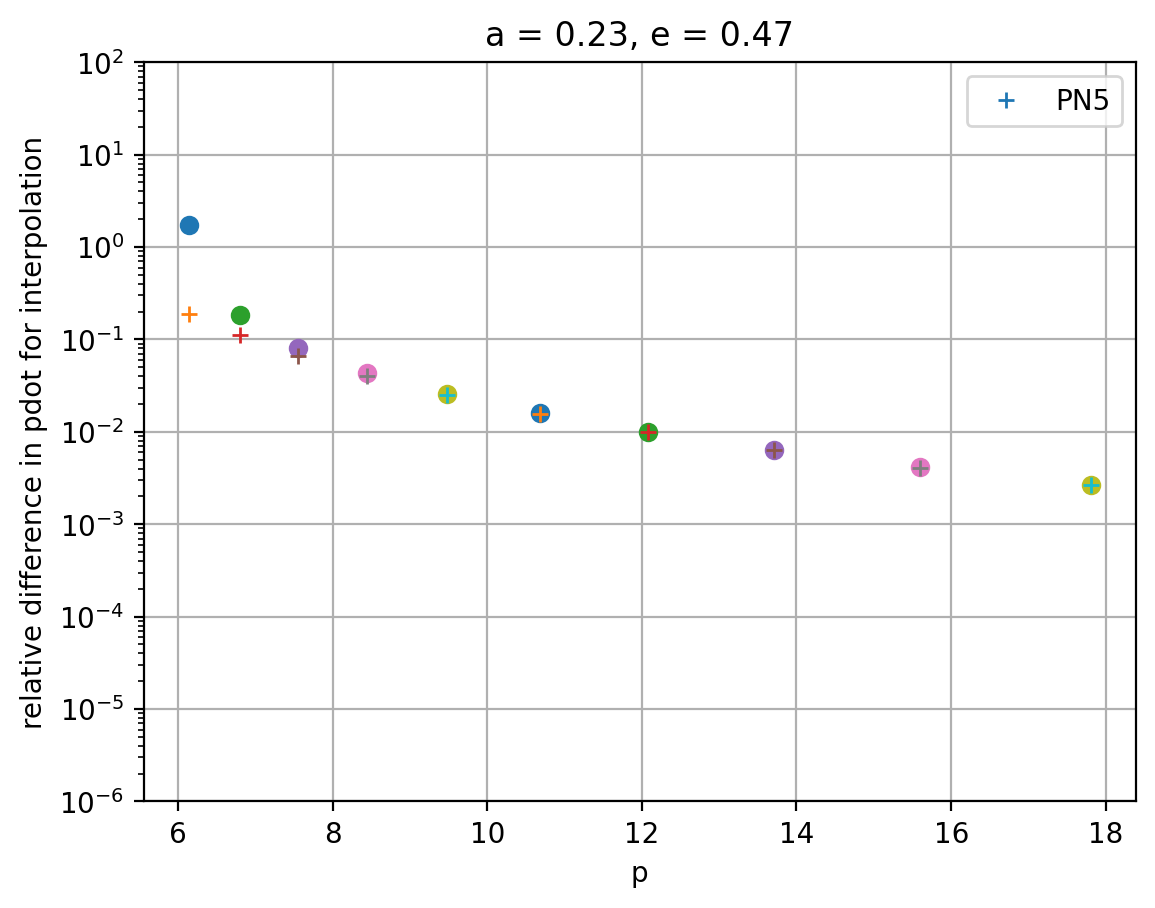

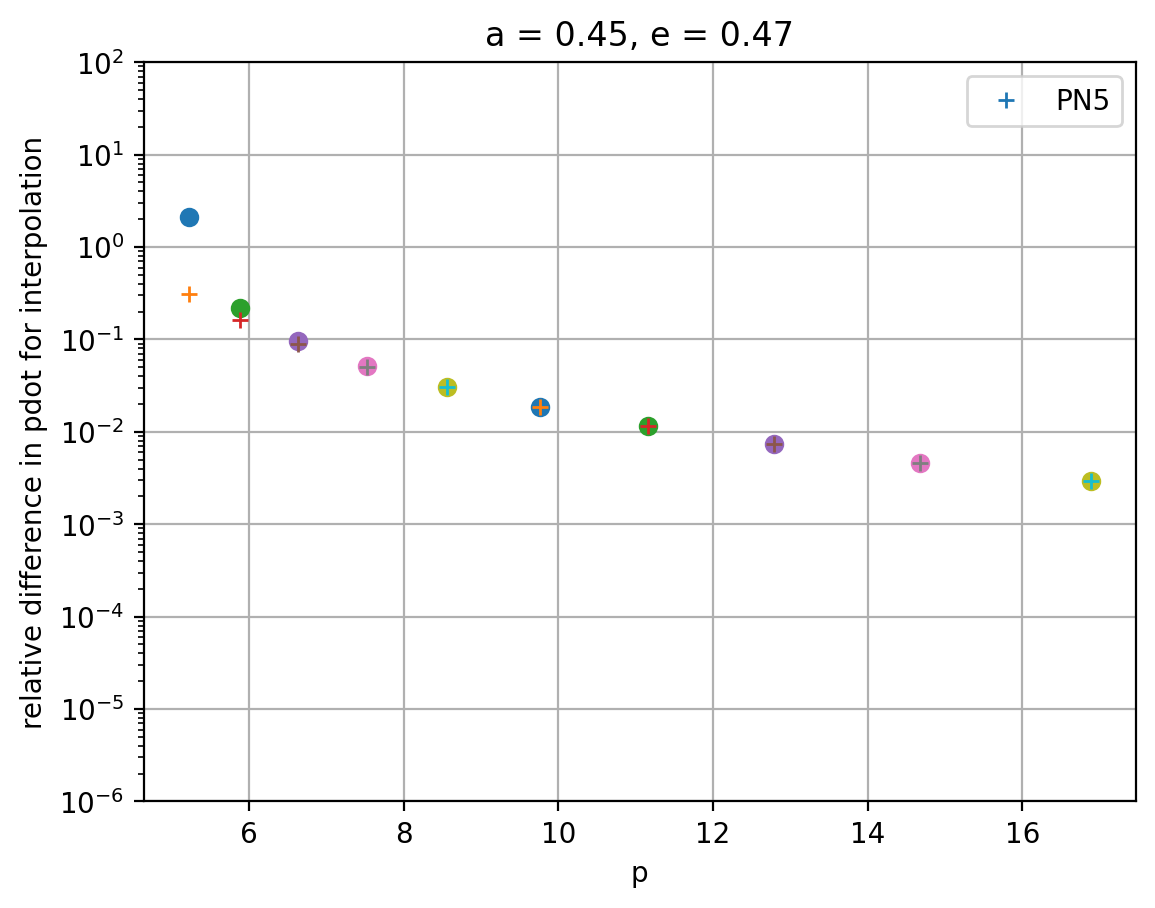

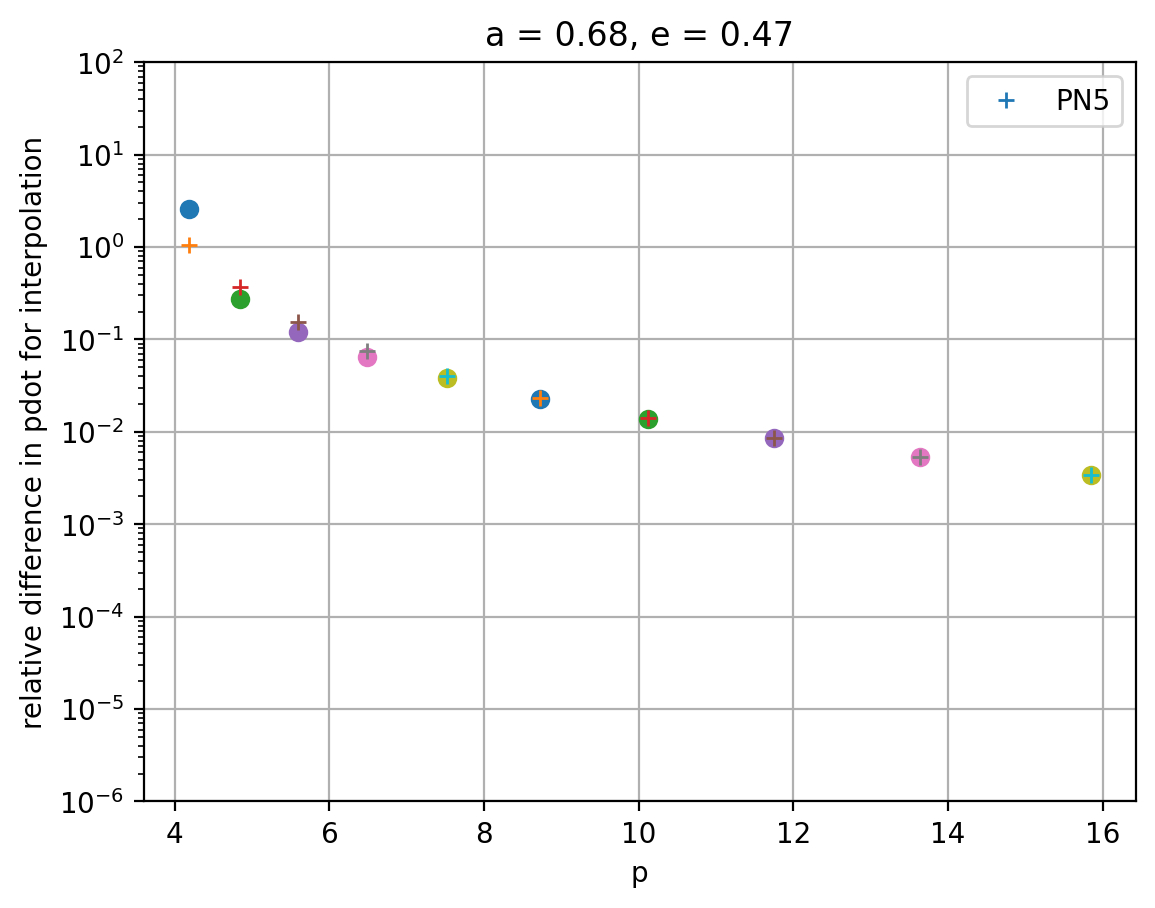

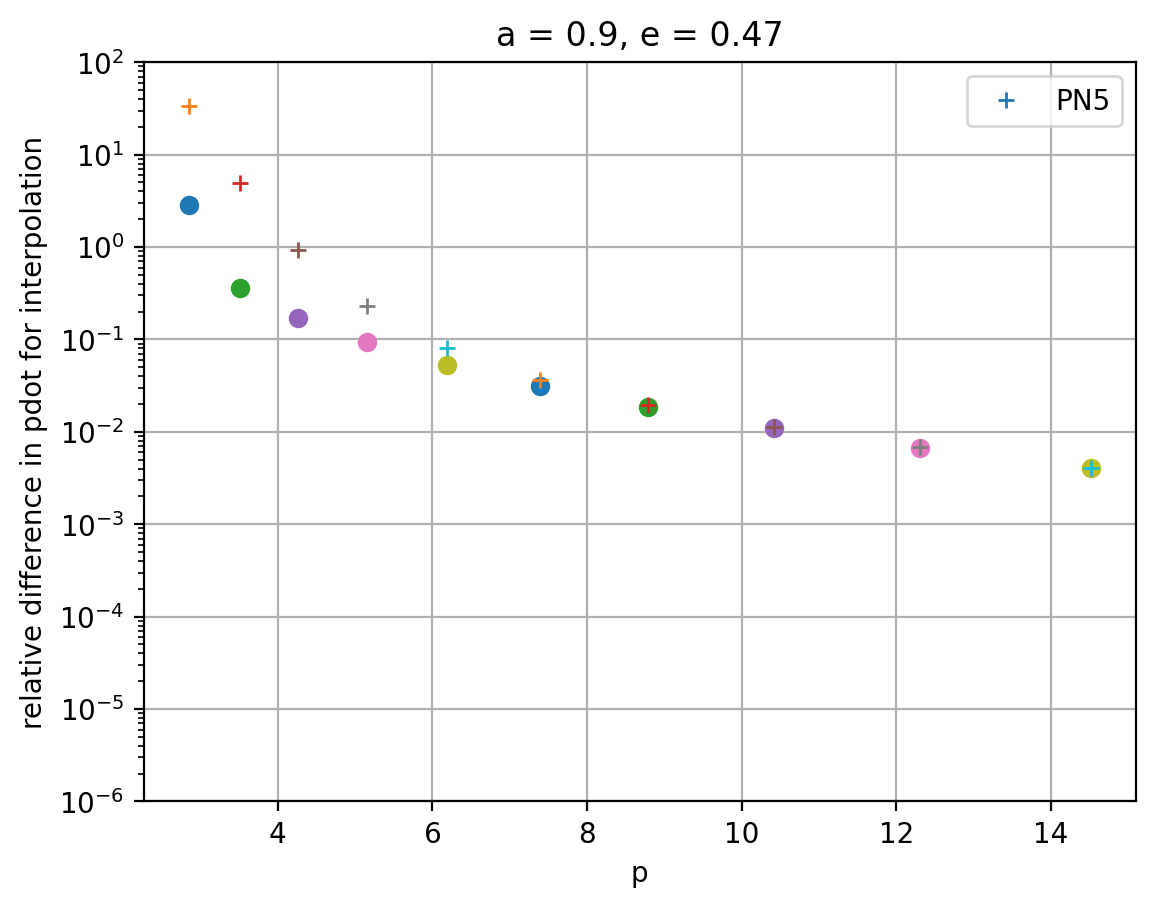

In [11]:
for A in np.linspace(x1.min(),x1.max(),num=5):
    plt.figure()
    for B in np.linspace(x2.min()+1e-4,x2.max(),num=10):
        C = np.linspace(x3.min()+1e-4,x3.max(),num=5)[1]
        test = (A,B,C)
        ee = np.sqrt(C)
        sep = get_separatrix(A, ee, 1.0)
        pp = np.exp(B)*alpha + sep - beta

#         plt.semilogy(pp, -ScipyFlux(test),'+')
#         plt.semilogy(pp, np.abs(1-InterpFlux(test)/f(*test)),'.')
        plt.semilogy(pp, -InterpFlux(test),'o')
        plt.semilogy(pp, -f(*test),'+')
#         plt.semilogy(pp, np.abs(1-InterpFlux(test)/(fS(*test)+1e-30)) ,'^')
#         plt.semilogy(pp, ,'x')
#         plt.semilogy(pp, -fS(*test),'^')
    plt.ylim([1e-6, 1e2])
    plt.title(f'a = {A:.2}, e = {ee:.2}')
    plt.xlabel('p')
    plt.ylabel('relative difference in pdot for interpolation')
    plt.semilogy(pp, 0.0*pp,'+',label='PN5')
#     plt.semilogy(pp, 0.0*pp,'^',label='Schwarz')
    plt.legend()
    
    plt.grid()
    plt.show()

# PN5 Interpolation

In [12]:
Nx1 = x1.shape[0]*4
Nx2 = x2.shape[0]*4
Nx3 = x3.shape[0]*4
newx1 = np.linspace(x1.min()+1e-5,x1.max(),num=Nx1)
newx2 = np.linspace(x2.min(),x2.max(),num=Nx2)
newx3 = np.linspace(x3.min()+1e-5,x3.max(),num=Nx3)
newX = [newx1,newx2,newx3]

pn5flux = []
for A in newx1:
    for B in newx2:
        for C in newx3:
            test = (A,B,C)
            ee = np.sqrt(C)
            sep = get_separatrix(A, ee, 1.0)
            pp = np.exp(B)*alpha + sep - beta
            pn5flux.append(f(*test))

In [13]:
flat_pn5 = np.asarray(pn5flux).flatten()
pn5_pdot = flat_pn5.reshape((Nx1, Nx2, Nx3))
InterpPN5pdot  = TPI.TP_Interpolant_ND(newX, F=pn5_pdot)

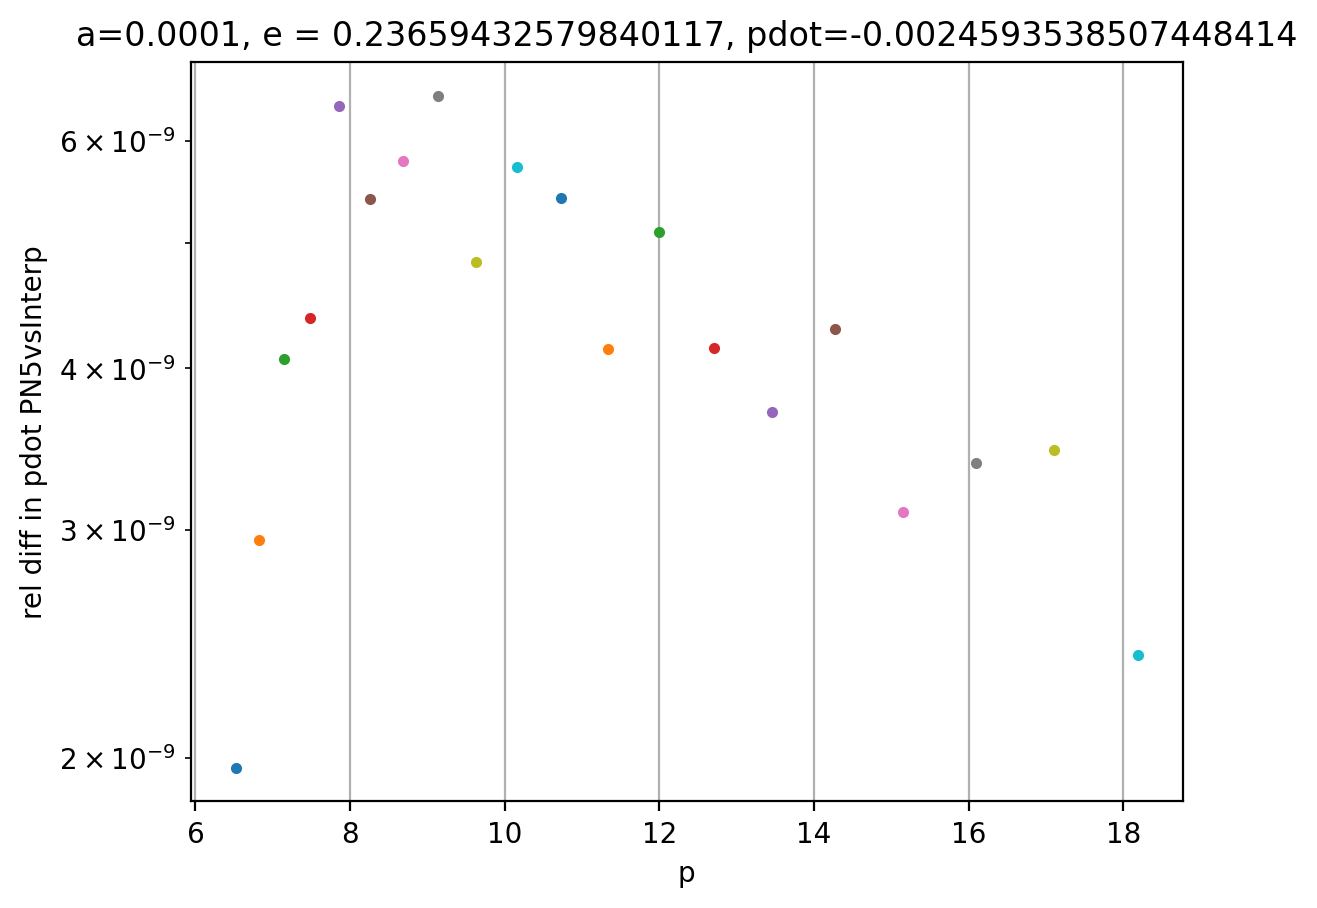

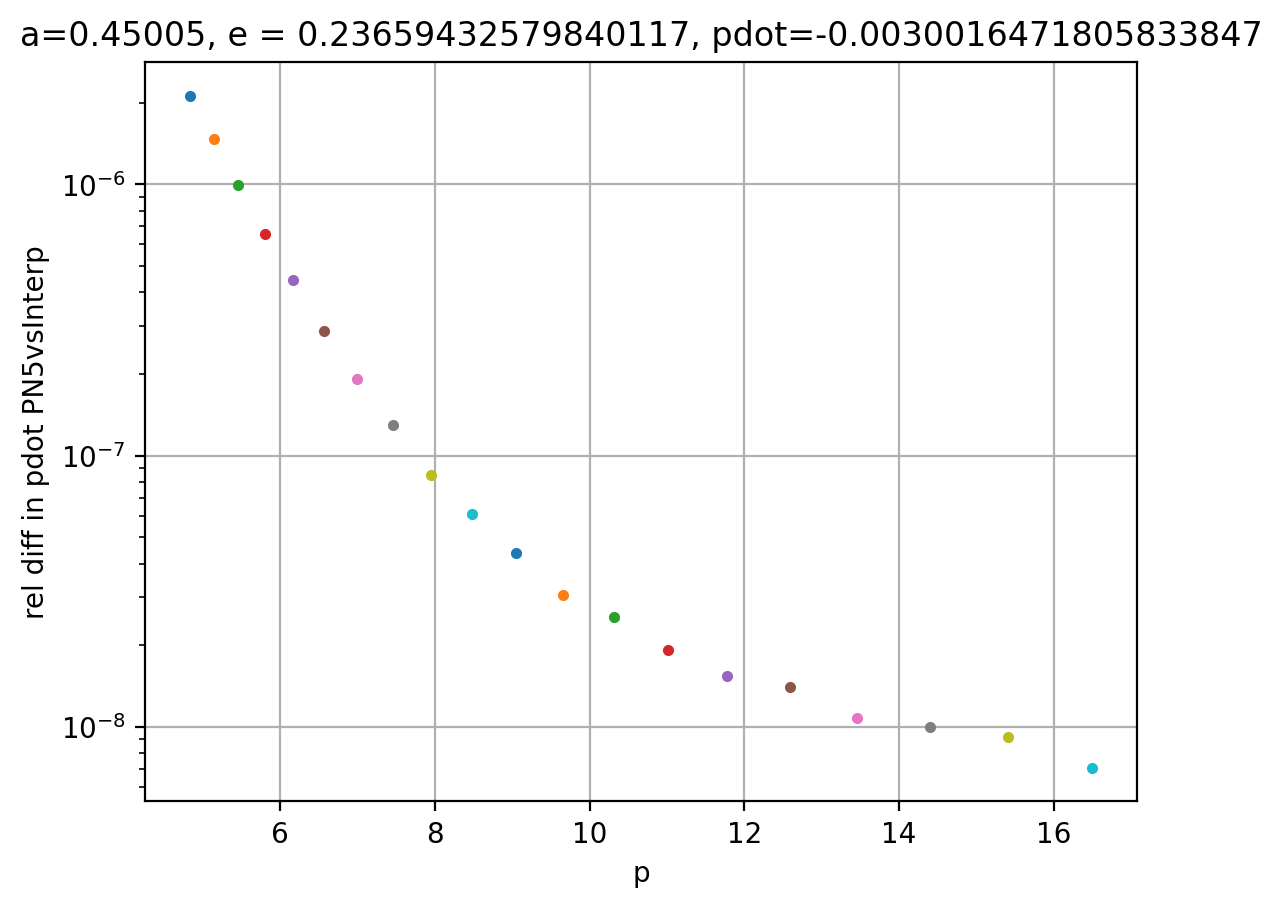

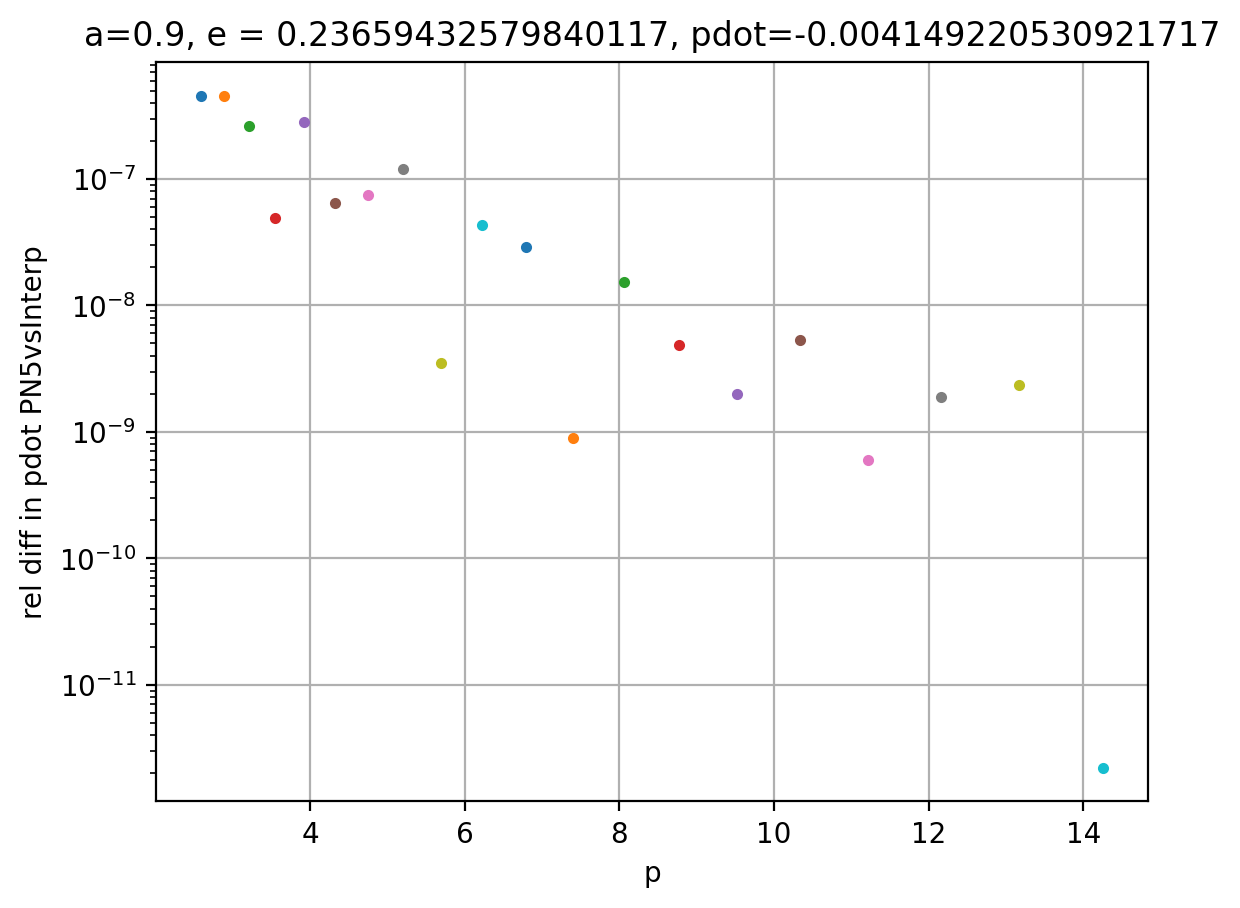

In [14]:
for A in np.linspace(x1.min()+1e-4,x1.max(),num=3):
    plt.figure()
    for B in np.linspace(x2.min()+1e-4,x2.max(),num=20):
        C = np.linspace(x3.min()+1e-4,x3.max()/4,num=5)[1]
        test = (A,B,C)
        ee = np.sqrt(C)
        sep = get_separatrix(A, ee, 1.0)
        pp = np.exp(B)*alpha + sep - beta

        plt.semilogy(pp, np.abs(1-InterpPN5pdot(test)/f(*test)),'.')
#         plt.semilogy(pp, np.abs(f(*test)-InterpPN5pdot(test)),'.')

    plt.title(f'a={A}, e = {ee}, pdot={f(*test)}')
    plt.xlabel('p')
    plt.ylabel('rel diff in pdot PN5vsInterp')
    plt.grid()
    plt.show()

In [16]:
%%timeit
InterpPN5pdot(test)

1.61 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
